# Libraries

In [159]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, GridSearchCV, RandomizedSearchCV

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Rescaling, Dropout, Activation, AvgPool2D

from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

In [2]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import text2emotion as te   

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cristina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Cristina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Cristina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Cristina\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load data

In [3]:
drugs_train = pd.read_csv(r'C:\Users\Cristina\OneDrive\Documentos\Curs SEPE\Projecte final\drug_review_train.csv')
drugs_test = pd.read_csv(r'C:\Users\Cristina\OneDrive\Documentos\Curs SEPE\Projecte final\drug_review_test.csv')
drugs_validation = pd.read_csv(r'C:\Users\Cristina\OneDrive\Documentos\Curs SEPE\Projecte final\drug_review_validation.csv')
drugs_train.head()

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74


In [4]:
# we need to combine the train, test and validation datasets because we need to process some info in them and probably add 
# columns and we need them to have the same columns to make the predictions

drugs = pd.concat([drugs_train, drugs_test, drugs_validation])
drugs.head()

,Unnamed: 0,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74


In [5]:
drugs.shape

(184622, 9)

# Clean data (preprocessing)

First of all, the first column "Unnamed:0" doesn't give us any information so we can drop it.

In [6]:
drugs = drugs.drop(['Unnamed: 0'], axis=1)
drugs

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74
...,...,...,...,...,...,...,...,...
27698,176929,Adalimumab,psoriatic arthritis,"""after my first and only shot, ten days after ...",1.0,"October 18, 2017",1,144
27699,153580,Velivet,birth control,"""i have been on velivet for about a year. it h...",6.0,"May 29, 2012",1,67
27700,207011,Zarah,birth control,"""i have been taking zarah for almost 3 months....",8.0,"May 3, 2014",20,127
27701,74831,Keppra,seizures,"""i had my first seizure february 2014 and was ...",3.0,"November 10, 2015",30,116


Now, we look for NaNs in our dataset.

## NaNs

In [7]:
drugs.isnull().sum()

patient_id       0
drugName         0
condition        0
review           0
rating           0
date             0
usefulCount      0
review_length    0
dtype: int64

In [8]:
drugs.dtypes

patient_id         int64
drugName          object
condition         object
review            object
rating           float64
date              object
usefulCount        int64
review_length      int64
dtype: object

# Exploratory Data Analysis (EDA)

In [9]:
# create a function
def sentiment_type(rating):
    if rating >= 0 and rating <=4:
        return 0
    else:
        return 1
# create a new column of label/class based on condition
drugs['sentiment'] = drugs['rating'].apply(sentiment_type)
drugs

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147,0
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136,1
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140,0
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104,1
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74,1
...,...,...,...,...,...,...,...,...,...
27698,176929,Adalimumab,psoriatic arthritis,"""after my first and only shot, ten days after ...",1.0,"October 18, 2017",1,144,0
27699,153580,Velivet,birth control,"""i have been on velivet for about a year. it h...",6.0,"May 29, 2012",1,67,1
27700,207011,Zarah,birth control,"""i have been taking zarah for almost 3 months....",8.0,"May 3, 2014",20,127,1
27701,74831,Keppra,seizures,"""i had my first seizure february 2014 and was ...",3.0,"November 10, 2015",30,116,0


In [10]:
# use the vader library to determine if a review is positive or negative

# Negative : Compound Score <= -0.05
# Neutral : Compound Score >-0.05 and < 0.05 
# Positive : Compound Score >= 0.05

analyzer = SentimentIntensityAnalyzer()
drugs['review_sent'] = drugs['review'].apply(analyzer.polarity_scores)
drugs_sent_int = pd.concat([drugs.drop(['review_sent'], axis=1), drugs['review_sent'].apply(pd.Series)], axis=1)

In [11]:
drugs_sent_int.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,neg,neu,pos,compound
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,"April 20, 2013",69,147,0,0.100,0.858,0.042,-0.8748
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,"August 7, 2016",4,136,1,0.014,0.877,0.109,0.9330
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,"May 11, 2016",6,140,0,0.070,0.870,0.060,-0.3226
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,"March 19, 2012",124,104,1,0.037,0.844,0.118,0.8148
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,"August 1, 2010",101,74,1,0.021,0.802,0.177,0.9247


In [12]:
drugs_sent_int.loc[drugs_sent_int['drugName'] == 'Keppra']

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,neg,neu,pos,compound
1354,74901,Keppra,seizures,"""keppra alone did not do anything for me excep...",4.0,"December 4, 2009",18,118,0,0.095,0.866,0.039,-0.7615
1421,74866,Keppra,epilepsy,"""i am on a very small dose for epilepsy 250mg ...",8.0,"March 10, 2012",25,46,1,0.228,0.683,0.090,-0.7404
1825,74805,Keppra,epilepsy,"""the only few problems consists of drowsiness ...",8.0,"June 24, 2013",26,46,1,0.056,0.807,0.137,0.4404
2246,74932,Keppra,seizures,"""i had brain surgery in december 1996. a tumor...",9.0,"July 16, 2008",41,64,1,0.029,0.910,0.061,0.4678
3560,74828,Keppra,seizures,"""my last seizure was less than a month before ...",10.0,"January 12, 2016",43,99,1,0.091,0.857,0.052,-0.5816
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22443,74800,Keppra,seizures,"""i was given one dose of keppra as a precautio...",3.0,"November 1, 2013",43,82,0,0.227,0.693,0.080,-0.9082
22486,74777,Keppra,epilepsy,"""i was having difficulty getting diagnosed bec...",10.0,"February 13, 2015",33,111,1,0.104,0.879,0.017,-0.8249
25086,74739,Keppra,seizures,"""sometimes i feel drowsy, sometimes i feel diz...",8.0,"October 19, 2017",1,81,1,0.018,0.844,0.138,0.8649
25205,74759,Keppra,seizures,"""made me more aggressive lost nearly 50% of my...",1.0,"October 15, 2015",33,39,0,0.231,0.704,0.064,-0.7943


In [409]:
drugs_epilepsy = pd.DataFrame(drugs.loc[(drugs_sent_int['condition'] == 'seizures') | (drugs['condition'] == 'epilepsy') | 
                  (drugs['condition'] == 'seizure prevention')])
drugs_epilepsy.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,review_sent,eff_score
1001,229847,Fycompa,seizures,"""having tried 7 other medications none of whic...",10.0,"December 31, 2015",20,53,1,"{'neg': 0.058, 'neu': 0.785, 'pos': 0.157, 'co...",1
1102,219002,Depakote,epilepsy,"""i have been on depakote for a very long time....",9.0,"August 29, 2009",21,139,1,"{'neg': 0.085, 'neu': 0.856, 'pos': 0.059, 'co...",1
1122,115898,Divalproex sodium,epilepsy,"""i was on this med in europe before it was ava...",9.0,"December 29, 2009",3,78,1,"{'neg': 0.058, 'neu': 0.942, 'pos': 0.0, 'comp...",1
1151,113965,Tegretol,epilepsy,"""i have been diagnosed with absence seizures f...",9.0,"April 9, 2009",16,72,1,"{'neg': 0.093, 'neu': 0.834, 'pos': 0.073, 'co...",1
1186,116728,Lamictal,epilepsy,"""i started taking limictal about 7yrs ago 2x'...",9.0,"October 1, 2016",10,140,1,"{'neg': 0.137, 'neu': 0.736, 'pos': 0.126, 'co...",1


In [403]:
drugs_epilepsy['drugName'].unique()

array(['Fycompa', 'Depakote', 'Divalproex sodium', 'Tegretol', 'Lamictal',
       'Keppra', 'Lamotrigine', 'Levetiracetam', 'Lacosamide',
       'Zonisamide', 'Felbamate', 'Carbamazepine', 'Topamax', 'Depakene',
       'Zonegran', 'Phenytoin', 'Clonazepam', 'Tiagabine', 'Topiramate',
       'Vimpat', 'Dilantin', 'Eslicarbazepine', 'Felbatol',
       'Oxcarbazepine', 'Zarontin', 'Trileptal', 'Trokendi XR',
       'Primidone', 'Peganone', 'Ethosuximide', 'Keppra XR', 'Diazepam',
       'Epitol', 'Aptiom', 'Gabapentin', 'Perampanel', 'Mebaral',
       'Depakote ER', 'Phenytek', 'Valproic acid', 'Phenobarbital',
       'Klonopin', 'Gabitril', 'Mephobarbital', 'Briviact', 'Carbatrol',
       'Lyrica', 'Acetazolamide', 'Valium', 'Lamictal XR', 'Qudexy XR',
       'Diamox', 'Tegretol XR', 'Clobazam', 'Prometrium', 'Mysoline',
       'Topiragen', 'Pregabalin', 'Diastat AcuDial', 'Clorazepate',
       'Ethotoin', 'Progesterone', 'Neurontin', 'Magnesium sulfate',
       'Brivaracetam', 'Tranxene

In [13]:
# converting the date into datetime format
drugs_sent_int['date'] = pd.to_datetime(drugs_sent_int['date'], errors = 'coerce')

# now extracting year from date
drugs_sent_int['Year'] = drugs_sent_int['date'].dt.year

# extracting the month from the date
drugs_sent_int['month'] = drugs_sent_int['date'].dt.month

# extracting the days from the date
drugs_sent_int['day'] = drugs_sent_int['date'].dt.day

In [14]:
drugs_sent_int.head()

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length,sentiment,neg,neu,pos,compound,Year,month,day
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,2013-04-20,69,147,0,0.100,0.858,0.042,-0.8748,2013,4,20
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,2016-08-07,4,136,1,0.014,0.877,0.109,0.9330,2016,8,7
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,2016-05-11,6,140,0,0.070,0.870,0.060,-0.3226,2016,5,11
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,2012-03-19,124,104,1,0.037,0.844,0.118,0.8148,2012,3,19
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,2010-08-01,101,74,1,0.021,0.802,0.177,0.9247,2010,8,1


We don't need the date column anymore, as we already have it divided in 3 columns for year, month and day.

In [15]:
drugs_sent_int = drugs_sent_int.drop(['date'], axis=1)
drugs_sent_int

,patient_id,drugName,condition,review,rating,usefulCount,review_length,sentiment,neg,neu,pos,compound,Year,month,day
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,69,147,0,0.100,0.858,0.042,-0.8748,2013,4,20
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,4,136,1,0.014,0.877,0.109,0.9330,2016,8,7
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,6,140,0,0.070,0.870,0.060,-0.3226,2016,5,11
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,124,104,1,0.037,0.844,0.118,0.8148,2012,3,19
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,101,74,1,0.021,0.802,0.177,0.9247,2010,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27698,176929,Adalimumab,psoriatic arthritis,"""after my first and only shot, ten days after ...",1.0,1,144,0,0.121,0.774,0.105,-0.5379,2017,10,18
27699,153580,Velivet,birth control,"""i have been on velivet for about a year. it h...",6.0,1,67,1,0.148,0.659,0.193,0.5343,2012,5,29
27700,207011,Zarah,birth control,"""i have been taking zarah for almost 3 months....",8.0,20,127,1,0.069,0.810,0.121,0.8412,2014,5,3
27701,74831,Keppra,seizures,"""i had my first seizure february 2014 and was ...",3.0,30,116,0,0.100,0.818,0.082,-0.2617,2015,11,10


## Class distribution

<AxesSubplot:xlabel='sentiment', ylabel='count'>

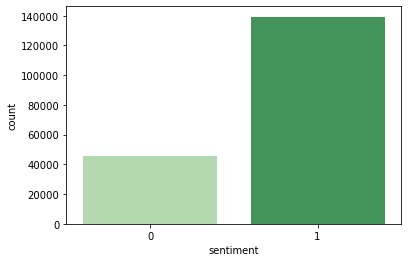

In [16]:
sns.countplot(data=drugs_sent_int, x="sentiment", palette='Greens')

<AxesSubplot:xlabel='sentiment', ylabel='count'>

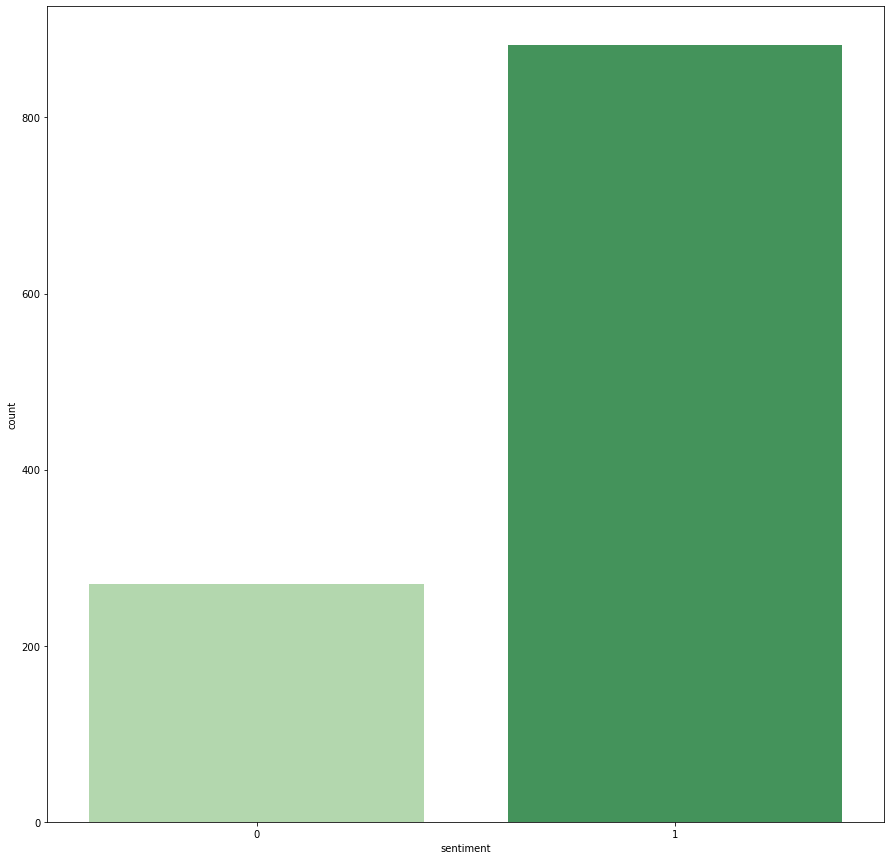

In [424]:
sns.countplot(data=drugs_epilepsy, x="sentiment", palette='Greens')

## Data visualization

### Drugs with highest rating

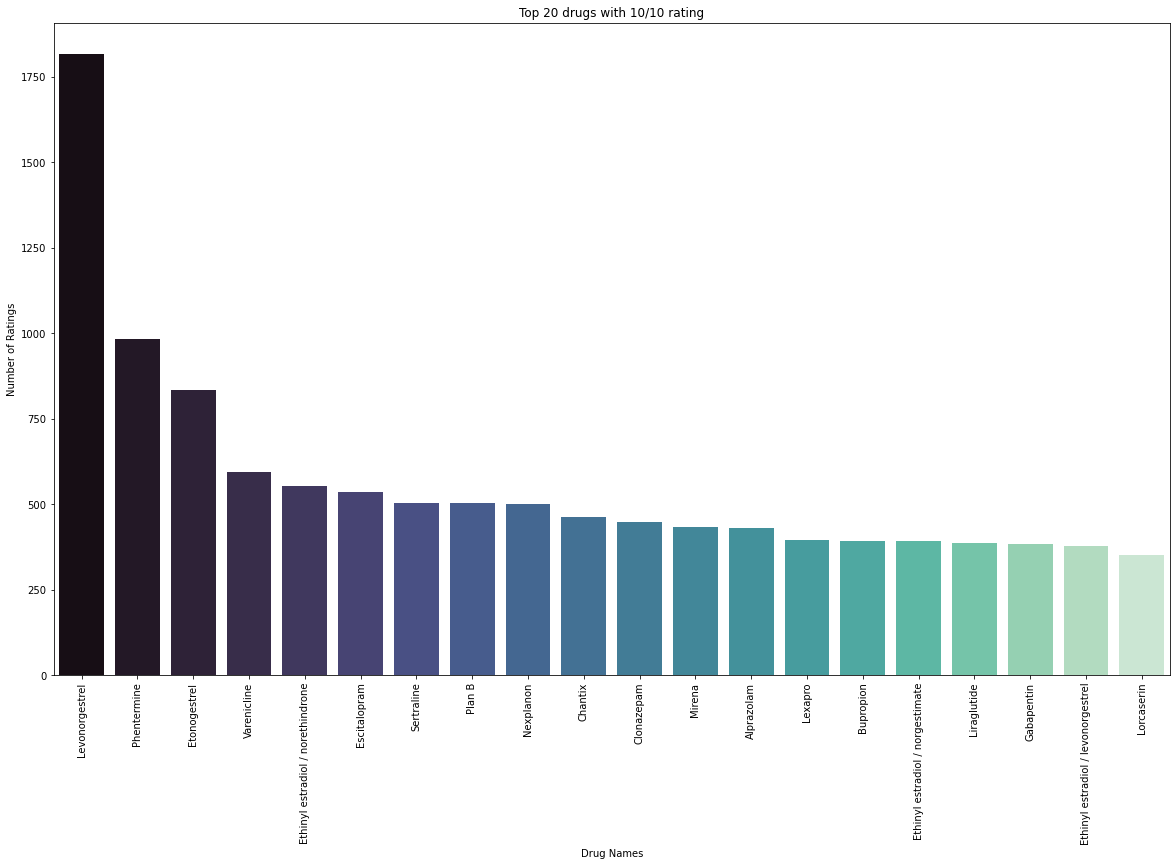

In [17]:
plt.figure(figsize=(20, 12))

rating = dict(drugs_sent_int.loc[drugs_sent_int.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'mako')

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

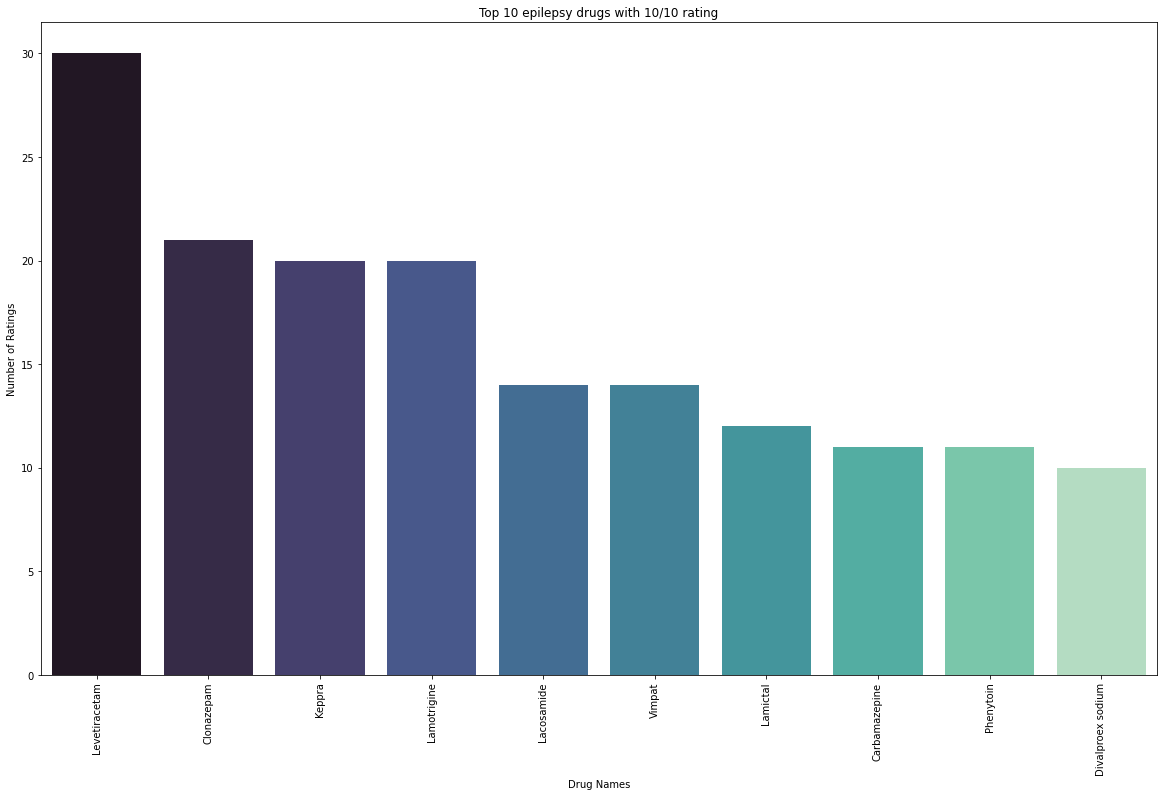

In [423]:
plt.figure(figsize=(20, 12))

rating = dict(drugs_epilepsy.loc[drugs_epilepsy.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:10], y = drug_rating[0:10], palette = 'mako')

sns_rating.set_title('Top 10 epilepsy drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

### Drugs with lowest rating

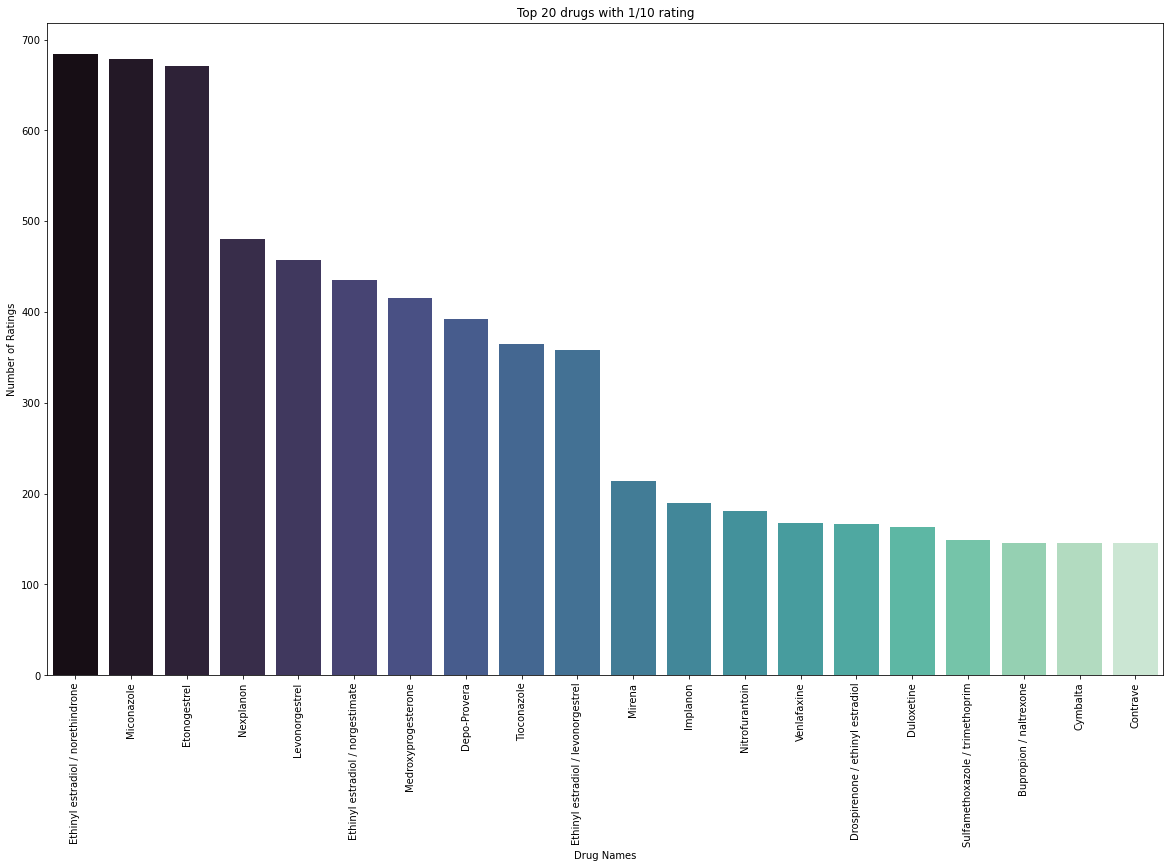

In [18]:
plt.figure(figsize=(20, 12))

rating = dict(drugs_sent_int.loc[drugs.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'mako')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

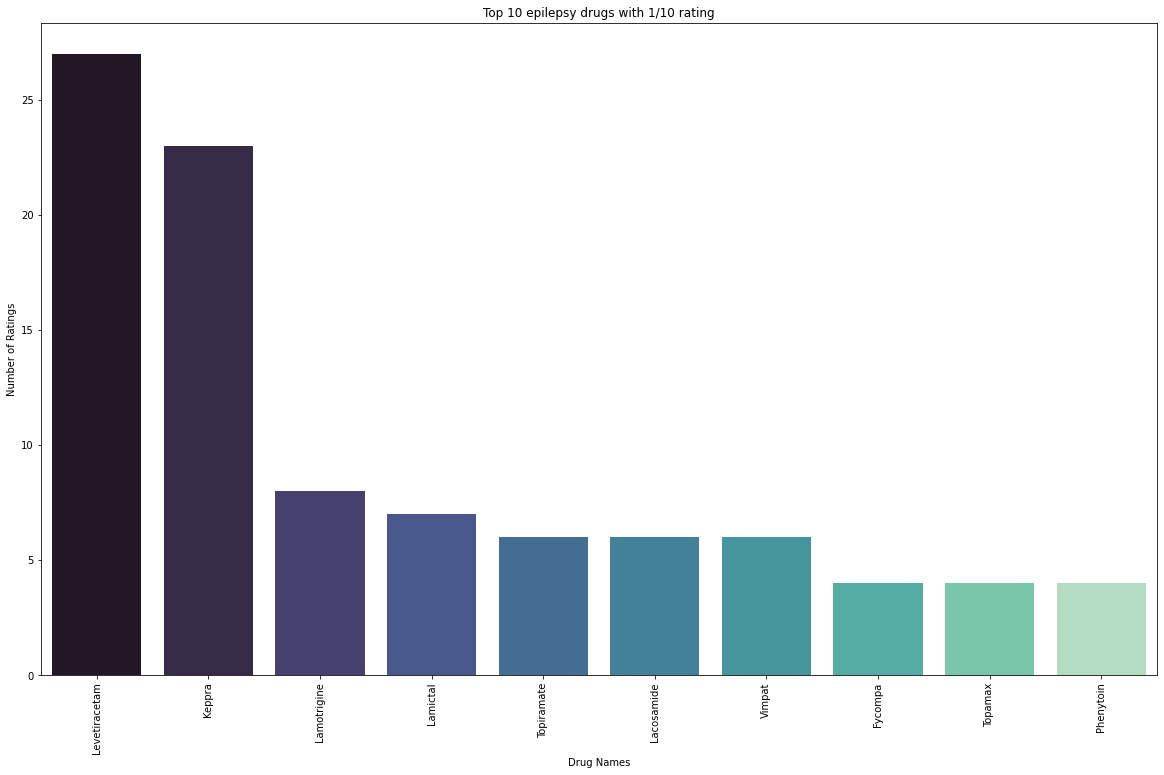

In [412]:
plt.figure(figsize=(20, 12))

rating = dict(drugs_epilepsy.loc[drugs_epilepsy.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:10], y = drug_rating[0:10], palette = 'mako')

sns_rating.set_title('Top 10 epilepsy drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

### Distribution of drugs rating

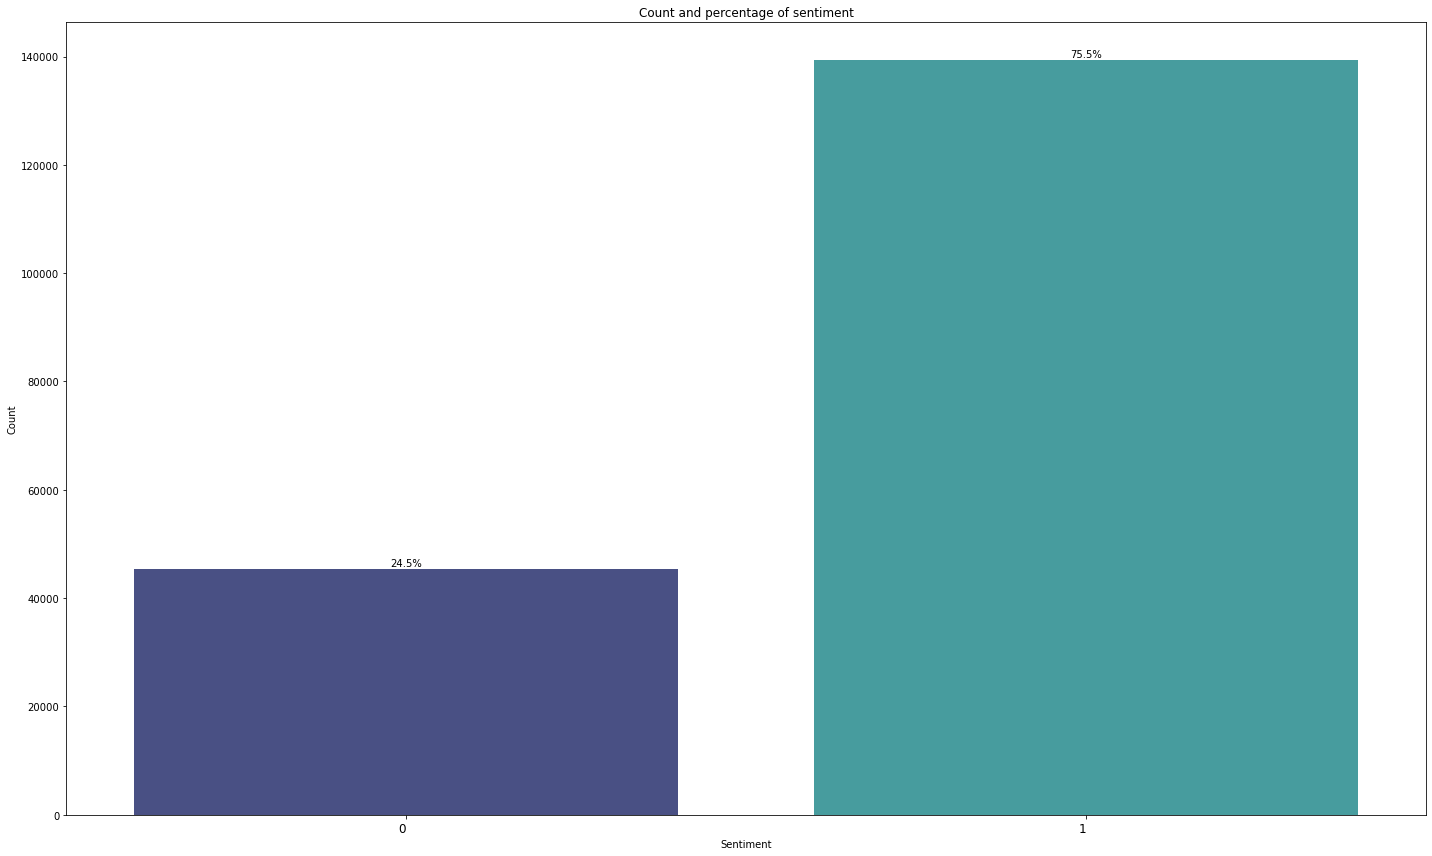

In [417]:
# Visualize the distribution of drugs sentiment

plt.figure(figsize=(20, 12))

ax = sns.countplot(data=drugs_sent_int, x='sentiment', palette='mako')
plt.xticks(size=12)
plt.xlabel('Sentiment', size=10)
plt.yticks(size=10)
plt.ylabel('Count', size=10)
plt.title("Count and percentage of sentiment", size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

total = len(drugs)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

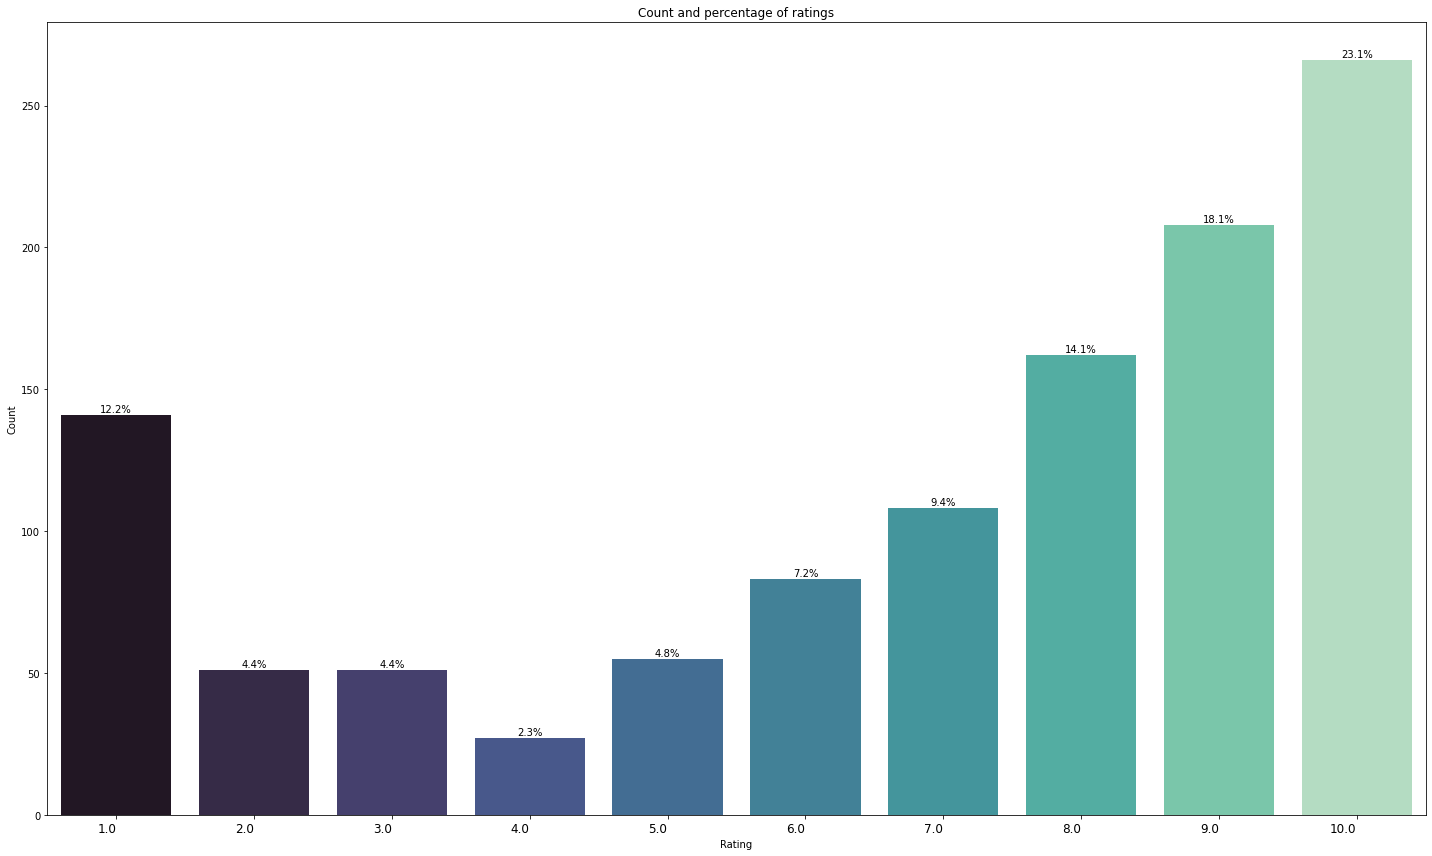

In [413]:
plt.figure(figsize=(20, 12))

ax = sns.countplot(data=drugs_epilepsy, x='rating', palette='mako')
plt.xticks(size=12)
plt.xlabel('Rating', size=10)
plt.yticks(size=10)
plt.ylabel('Count', size=10)
plt.title("Count and percentage of ratings", size=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")

total = len(drugs_epilepsy)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

### Top 15 conditions

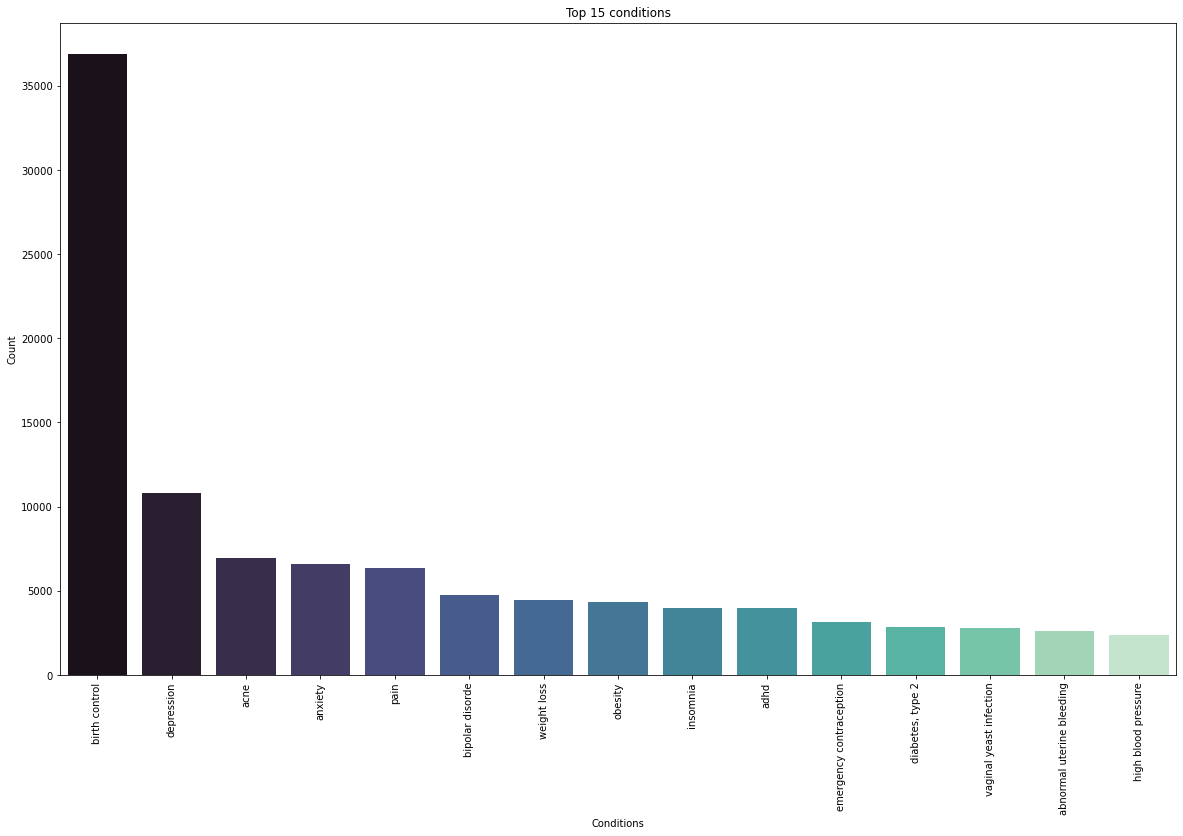

In [20]:
plt.figure(figsize=(20, 12))

cond = dict(drugs_sent_int['condition'].value_counts())
top_condition = list(cond.keys())[0:15]
values = list(cond.values())[0:15]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'mako')
sns_.set_title("Top 15 conditions")
sns_.set_xlabel("Conditions")
plt.xticks(rotation=90)
sns_.set_ylabel("Count");

In [355]:
newdf = drugs.copy()

In [376]:
import ipywidgets
from ipywidgets import interact

@interact
def check(condition = list(newdf['condition'].value_counts().index)):
    return newdf[newdf['condition'] == condition]['sentiment'].value_counts()

interactive(children=(Dropdown(description='condition', options=('birth control', 'depression', 'acne', 'anxie…

### Distribution of useful count

<Figure size 720x720 with 0 Axes>

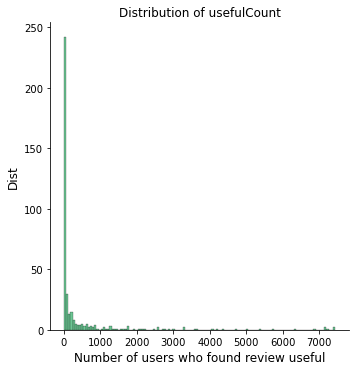

In [21]:
plt.figure(figsize=(10,10))

sns.displot(drugs_sent_int['usefulCount'].value_counts(), color = 'mediumseagreen')


plt.xlabel('Number of users who found review useful', size=12)
plt.ylabel('Dist', size=12)
plt.title("Distribution of usefulCount", size=12)


plt.show()

### Wordcloud reviews of most popular drugs

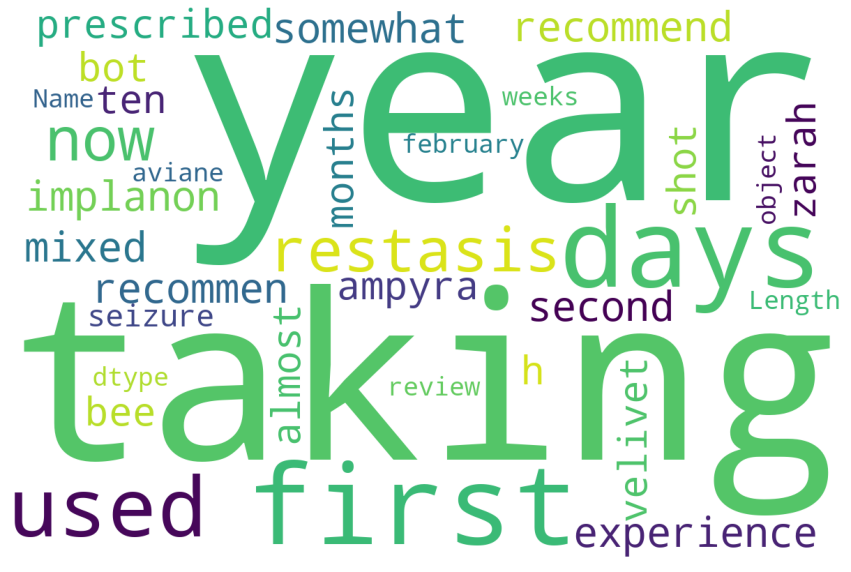

In [22]:

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, width = 1200, height = 800).generate(str(drugs_sent_int['review']))

plt.rcParams['figure.figsize'] = (15, 15)

print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

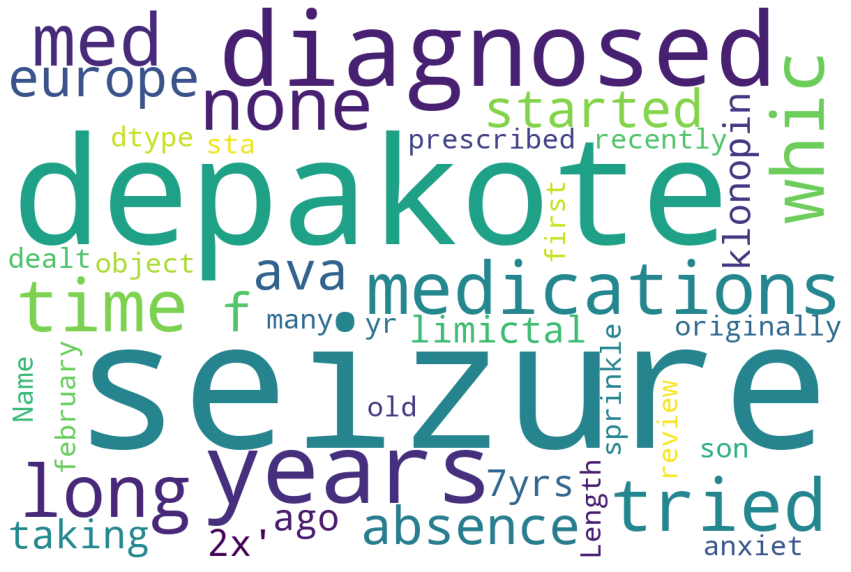

In [420]:
wordcloud2 = WordCloud(background_color = 'white', width = 1200, height = 800).generate(str(drugs_epilepsy['review']))

plt.rcParams['figure.figsize'] = (15, 15)

print(wordcloud2)
plt.axis('off')
plt.imshow(wordcloud2)
plt.show()

### Wordcloud positive sentiments

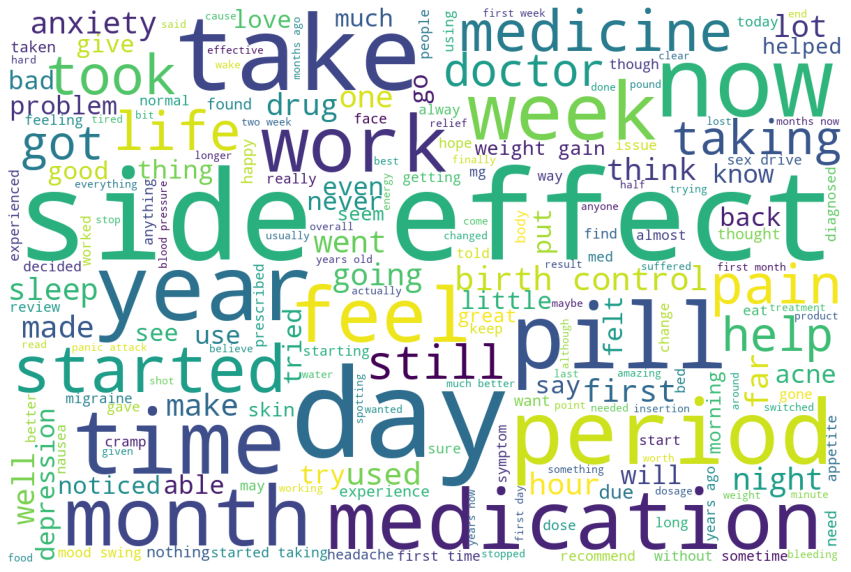

In [23]:
positive_sentiments = " ".join([text for text in drugs_sent_int['review'][drugs['sentiment'] == 1]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)

print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

### Wordcloud negative sentiments

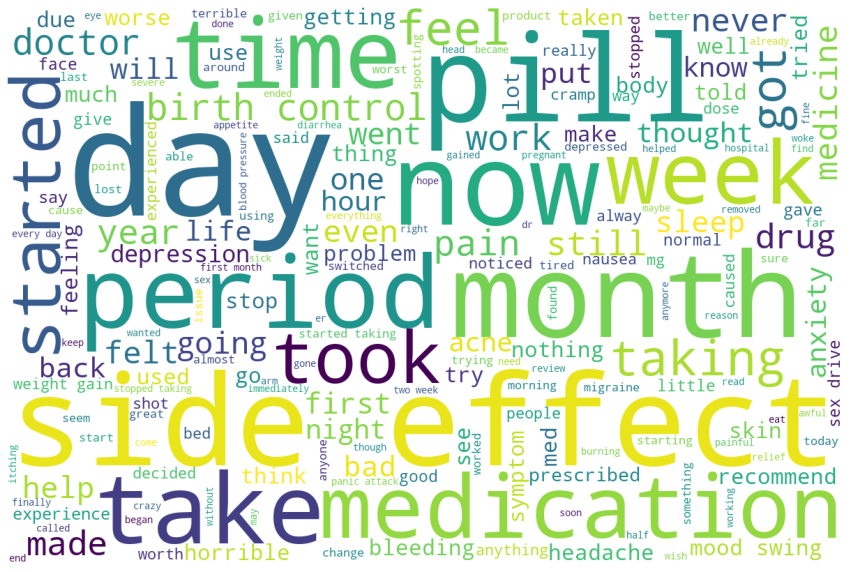

In [24]:
negative_sentiments = " ".join([text for text in drugs_sent_int['review'][drugs_sent_int['sentiment'] == 0]])

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)

print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

# Feature engineering

## Cleaning text

In [25]:
def review_clean(review): 
    # changing to lower case
    lower = review.str.lower()
    
    # Replacing the repeating pattern of &#039;
    pattern_remove = lower.str.replace("&#039;", "")
    
    # Removing all the special Characters
    special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
    
    # Removing all the non ASCII characters
    ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
    
    # Removing the leading and trailing Whitespaces
    whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
    
    # Replacing multiple Spaces with Single Space
    multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
    
    # Replacing Two or more dots with one
    dataframe = multiw_remove.str.replace(r'\.{2,}', ' ')
    
    return dataframe

In [26]:
drugs_sent_int['review_clean'] = review_clean(drugs_sent_int['review'])

C:\Users\Cristina\AppData\Local\Temp/ipykernel_11556/3584754075.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  special_remove = pattern_remove.str.replace(r'[^\w\d\s]',' ')
C:\Users\Cristina\AppData\Local\Temp/ipykernel_11556/3584754075.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  ascii_remove = special_remove.str.replace(r'[^\x00-\x7F]+',' ')
C:\Users\Cristina\AppData\Local\Temp/ipykernel_11556/3584754075.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  whitespace_remove = ascii_remove.str.replace(r'^\s+|\s+?$','')
C:\Users\Cristina\AppData\Local\Temp/ipykernel_11556/3584754075.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  multiw_remove = whitespace_remove.str.replace(r'\s+',' ')
C:\Users\Cristina\AppData\Local\Temp/ipykernel_11556/3584754075.py:21: FutureWarning: 

In [27]:
drugs_sent_int.head(10)

,patient_id,drugName,condition,review,rating,usefulCount,review_length,sentiment,neg,neu,pos,compound,Year,month,day,review_clean
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,69,147,0,0.100,0.858,0.042,-0.8748,2013,4,20,i have used restasis for about a year now and ...
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,4,136,1,0.014,0.877,0.109,0.9330,2016,8,7,my experience has been somewhat mixed i have b...
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,6,140,0,0.070,0.870,0.060,-0.3226,2016,5,11,this is my second implanon would not recommend...
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,124,104,1,0.037,0.844,0.118,0.8148,2012,3,19,i recommend taking as prescribed and the bottl...
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,101,74,1,0.021,0.802,0.177,0.9247,2010,8,1,i have been on ampyra for 5 days and have been...
5,218554,Tri-Sprintec,birth control,"""used for birth control and period issues- ver...",2.0,4,57,0,0.208,0.708,0.084,-0.7528,2017,1,7,used for birth control and period issues very ...
6,207442,Suprep Bowel Prep Kit,bowel preparation,"""my prep instructions were one 6oz bottle the ...",8.0,18,86,1,0.035,0.904,0.061,0.2999,2016,12,5,my prep instructions were one 6oz bottle the e...
7,63753,Epiduo,acne,"""love it. i had the worst breakouts, so i got ...",9.0,20,63,1,0.062,0.772,0.166,0.7845,2011,10,19,love it i had the worst breakouts so i got epi...
8,140845,Escitalopram,depression,"""i felt a positive difference within the first...",9.0,13,49,1,0.029,0.845,0.126,0.5346,2016,4,21,i felt a positive difference within the first ...
9,182520,Mirena,birth control,"""i have been on mirena for over a year now and...",1.0,45,37,0,0.260,0.740,0.000,-0.8720,2009,6,15,i have been on mirena for over a year now and ...


## Remove stopwords

In [28]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

#remove stopwords

drugs_sent_int['review_clean'] = drugs_sent_int['review_clean'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

## Stem text

In [29]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

drugs_sent_int['review_clean'] = drugs_sent_int['review_clean'].apply(lambda x: " ".join(ps.stem(word) for word in x.split()))

In [30]:
drugs_sent_int.head()

,patient_id,drugName,condition,review,rating,usefulCount,review_length,sentiment,neg,neu,pos,compound,Year,month,day,review_clean
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,69,147,0,0.100,0.858,0.042,-0.8748,2013,4,20,use restasi year seen almost progress life red...
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,4,136,1,0.014,0.877,0.109,0.9330,2016,8,7,experi somewhat mix use implanon nearli 14 mon...
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,6,140,0,0.070,0.870,0.060,-0.3226,2016,5,11,second implanon would recommend first one okay...
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,124,104,1,0.037,0.844,0.118,0.8148,2012,3,19,recommend take prescrib bottl usual say take x...
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,101,74,1,0.021,0.802,0.177,0.9247,2010,8,1,ampyra 5 day happi new pill first 2 day good s...


## Add some columns

In [31]:
#Word count in each review
drugs_sent_int['count_word'] = drugs_sent_int["review_clean"].apply(lambda x: len(str(x).split()))

#Unique word count 
drugs_sent_int['count_unique_word'] = drugs_sent_int["review_clean"].apply(lambda x: len(set(str(x).split())))

#Average length of the words
drugs_sent_int["mean_word_len"] = drugs_sent_int["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

## Sentiment polarity and subjectivity

In [32]:
from textblob import TextBlob

def polarity(review):
    # Sentiment polarity of the reviews
    pol = []
    for i in review:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol


def subjectivity(review):
    # Sentiment subjectivity of the reviews
    sub = []
    for i in review:
        analysis = TextBlob(i)
        sub.append(analysis.sentiment.subjectivity)
    return sub

In [33]:
drugs_sent_int['sentiment_pol'] = polarity(drugs_sent_int['review_clean'])
drugs_sent_int['sentiment_sub'] = subjectivity(drugs_sent_int['review_clean'])

In [34]:
drugs_sent_int.head()

,patient_id,drugName,condition,review,rating,usefulCount,review_length,sentiment,neg,neu,...,compound,Year,month,day,review_clean,count_word,count_unique_word,mean_word_len,sentiment_pol,sentiment_sub
0,89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",2.0,69,147,0,0.100,0.858,...,-0.8748,2013,4,20,use restasi year seen almost progress life red...,68,51,4.514706,0.162500,0.329167
1,143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",7.0,4,136,1,0.014,0.877,...,0.9330,2016,8,7,experi somewhat mix use implanon nearli 14 mon...,66,52,5.015152,0.097245,0.478444
2,106473,Implanon,birth control,"""this is my second implanon would not recommen...",1.0,6,140,0,0.070,0.870,...,-0.3226,2016,5,11,second implanon would recommend first one okay...,55,45,4.927273,0.185185,0.381481
3,184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",10.0,124,104,1,0.037,0.844,...,0.8148,2012,3,19,recommend take prescrib bottl usual say take x...,50,43,4.780000,0.166667,0.361111
4,91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",9.0,101,74,1,0.021,0.802,...,0.9247,2010,8,1,ampyra 5 day happi new pill first 2 day good s...,37,30,4.459459,0.245909,0.356780


In [437]:
drugs_sent_int[drugs_sent_int.condition == 'seizures']['review'].iloc[0]

'"having tried 7 other medications none of which controlled my seizures i was happily surprised that a dose of 4mg of fycompa does. more than 12 months and no seizures. luckily i have not experienced suicidal thoughts. the only side effects i experience are a little aggression and tiredness but only very mild."'

In [439]:
drugs_sent_int[drugs_sent_int.condition == 'seizures']['review'].iloc[5]

'"had a brain tumor removed in 1988 and was on dilantin and phenobarbital for over 20 years. got rushed to the hospital for what was thought to be a stroke and ended up being a seizure. my new nuero dr. put me on keppra with phenobarbital, this worked great for about 5 years. just got out of the hospital again because of a seizure and am now on 3,000 mg of keppra and 400 mg of zonisamide daily. at first, i had a hard time sleeping,only about an hour a day, my fault, as i read the prescription bottle wrong. i was suppose to take the zonisamide once in the morning and here i was taking 200 mg in the morning and 200 mg at night. so far everything is fine as i am only on week 1 of my new dosage. my dr. also wants me to lose weight, so this is it."'

In [438]:
drugs_sent_int[drugs_sent_int.condition == 'seizures']['review_clean'].iloc[0]

'tri 7 medic none control seizur happili surpris dose 4mg fycompa 12 month seizur luckili experienc suicid thought side effect experi littl aggress tired mild'

In [440]:
drugs_sent_int[drugs_sent_int.condition == 'seizures']['review_clean'].iloc[5]

'brain tumor remov 1988 dilantin phenobarbit 20 year got rush hospit thought stroke end seizur new nuero dr put keppra phenobarbit work great 5 year got hospit seizur 3 000 mg keppra 400 mg zonisamid daili first hard time sleep hour day fault read prescript bottl wrong suppos take zonisamid morn take 200 mg morn 200 mg night far everyth fine week 1 new dosag dr also want lose weight'

## Correlation matrix

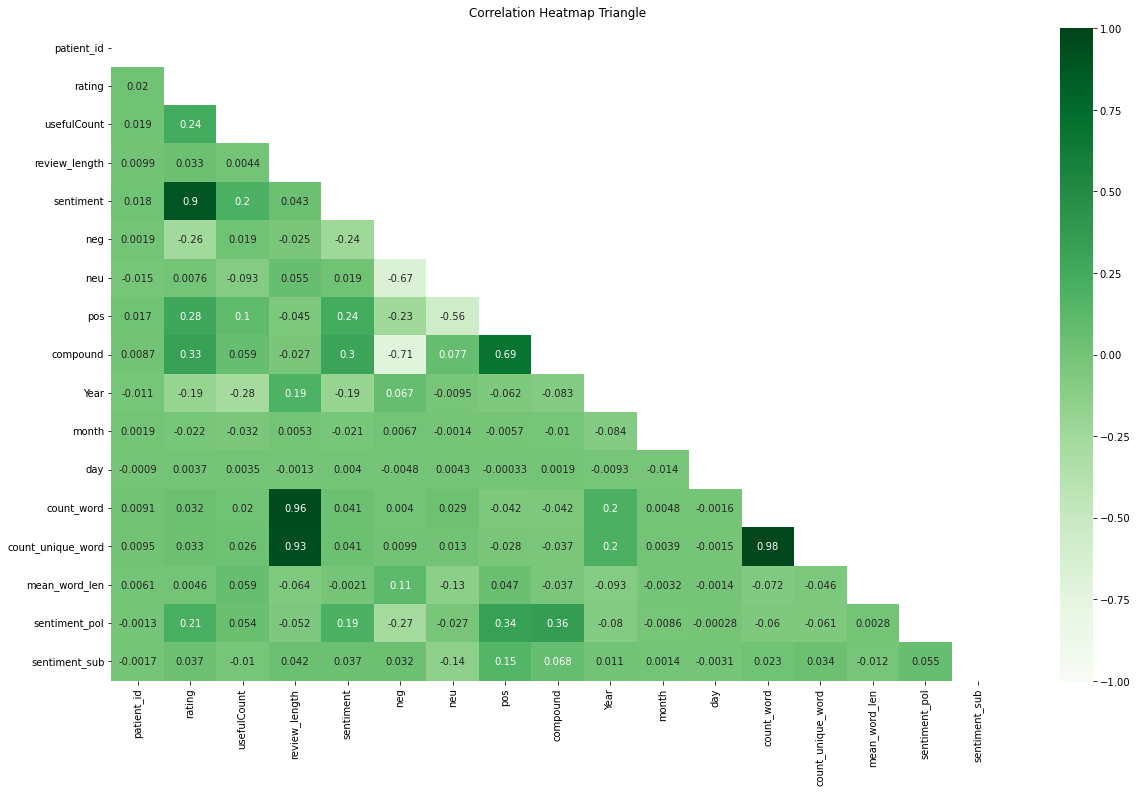

In [35]:
# Increase the size of the heatmap.
plt.figure(figsize=(20, 12))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(drugs_sent_int.corr(), vmin=-1, vmax=1, annot=True, mask= np.triu(drugs_sent_int.corr()), cmap="Greens")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap Triangle', fontdict={'fontsize':12}, pad=12);

In [36]:
# Drop rating and pacient_id because one is not giving any information and the other one is highly correlated with the class

drugs_sent_int = drugs_sent_int.drop(['patient_id', 'rating'], axis=1)
drugs_sent_int.head()

,drugName,condition,review,usefulCount,review_length,sentiment,neg,neu,pos,compound,Year,month,day,review_clean,count_word,count_unique_word,mean_word_len,sentiment_pol,sentiment_sub
0,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",69,147,0,0.100,0.858,0.042,-0.8748,2013,4,20,use restasi year seen almost progress life red...,68,51,4.514706,0.162500,0.329167
1,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",4,136,1,0.014,0.877,0.109,0.9330,2016,8,7,experi somewhat mix use implanon nearli 14 mon...,66,52,5.015152,0.097245,0.478444
2,Implanon,birth control,"""this is my second implanon would not recommen...",6,140,0,0.070,0.870,0.060,-0.3226,2016,5,11,second implanon would recommend first one okay...,55,45,4.927273,0.185185,0.381481
3,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",124,104,1,0.037,0.844,0.118,0.8148,2012,3,19,recommend take prescrib bottl usual say take x...,50,43,4.780000,0.166667,0.361111
4,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",101,74,1,0.021,0.802,0.177,0.9247,2010,8,1,ampyra 5 day happi new pill first 2 day good s...,37,30,4.459459,0.245909,0.356780


In [37]:
#move the class column to last position
drugs_sent_int = drugs_sent_int.reindex(columns = [col for col in drugs_sent_int.columns if col != 'neg'] + ['neg'])
drugs_sent_int = drugs_sent_int.reindex(columns = [col for col in drugs_sent_int.columns if col != 'neu'] + ['neu'])
drugs_sent_int = drugs_sent_int.reindex(columns = [col for col in drugs_sent_int.columns if col != 'pos'] + ['pos'])
drugs_sent_int = drugs_sent_int.reindex(columns = [col for col in drugs_sent_int.columns if col != 'compound'] + ['compound'])
drugs_sent_int = drugs_sent_int.reindex(columns = [col for col in drugs_sent_int.columns if col != 'sentiment'] + ['sentiment'])
drugs_sent_int.head()

,drugName,condition,review,usefulCount,review_length,Year,month,day,review_clean,count_word,count_unique_word,mean_word_len,sentiment_pol,sentiment_sub,neg,neu,pos,compound,sentiment
0,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",69,147,2013,4,20,use restasi year seen almost progress life red...,68,51,4.514706,0.162500,0.329167,0.100,0.858,0.042,-0.8748,0
1,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",4,136,2016,8,7,experi somewhat mix use implanon nearli 14 mon...,66,52,5.015152,0.097245,0.478444,0.014,0.877,0.109,0.9330,1
2,Implanon,birth control,"""this is my second implanon would not recommen...",6,140,2016,5,11,second implanon would recommend first one okay...,55,45,4.927273,0.185185,0.381481,0.070,0.870,0.060,-0.3226,0
3,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",124,104,2012,3,19,recommend take prescrib bottl usual say take x...,50,43,4.780000,0.166667,0.361111,0.037,0.844,0.118,0.8148,1
4,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",101,74,2010,8,1,ampyra 5 day happi new pill first 2 day good s...,37,30,4.459459,0.245909,0.356780,0.021,0.802,0.177,0.9247,1


In [38]:
drugs_sent_int.describe()

,usefulCount,review_length,Year,month,day,count_word,count_unique_word,mean_word_len,sentiment_pol,sentiment_sub,neg,neu,pos,compound,sentiment
count,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000,184622.000000
mean,28.457139,95.386238,2014.125678,6.512138,15.642193,47.458965,40.586539,4.782621,0.078181,0.411234,0.110501,0.791897,0.097603,-0.054518,0.754683
std,37.424977,38.566541,2.618185,3.419079,8.778390,19.542009,15.301012,0.372951,0.209516,0.180075,0.069715,0.081964,0.062494,0.704680,0.430276
min,0.000000,31.000000,2008.000000,1.000000,1.000000,8.000000,8.000000,2.933333,-1.000000,0.000000,0.000000,0.344000,0.000000,-0.998500,0.000000
25%,6.000000,63.000000,2012.000000,4.000000,8.000000,31.000000,28.000000,4.538462,-0.025000,0.305556,0.060000,0.739000,0.053000,-0.771000,1.000000
50%,16.000000,95.000000,2015.000000,7.000000,16.000000,47.000000,41.000000,4.772727,0.074408,0.412729,0.101000,0.796000,0.090000,-0.133200,1.000000
75%,37.000000,130.000000,2016.000000,9.000000,23.000000,64.000000,53.000000,5.014493,0.195000,0.520000,0.152000,0.849000,0.135000,0.680000,1.000000
max,1291.000000,1894.000000,2017.000000,12.000000,31.000000,919.000000,499.000000,7.687500,1.000000,1.000000,0.570000,1.000000,0.555000,0.996100,1.000000


In [39]:
# feature correlations with sentiment
drugs_corrs = drugs_sent_int.corr()['sentiment'].sort_values(ascending=False)[1:].to_frame()

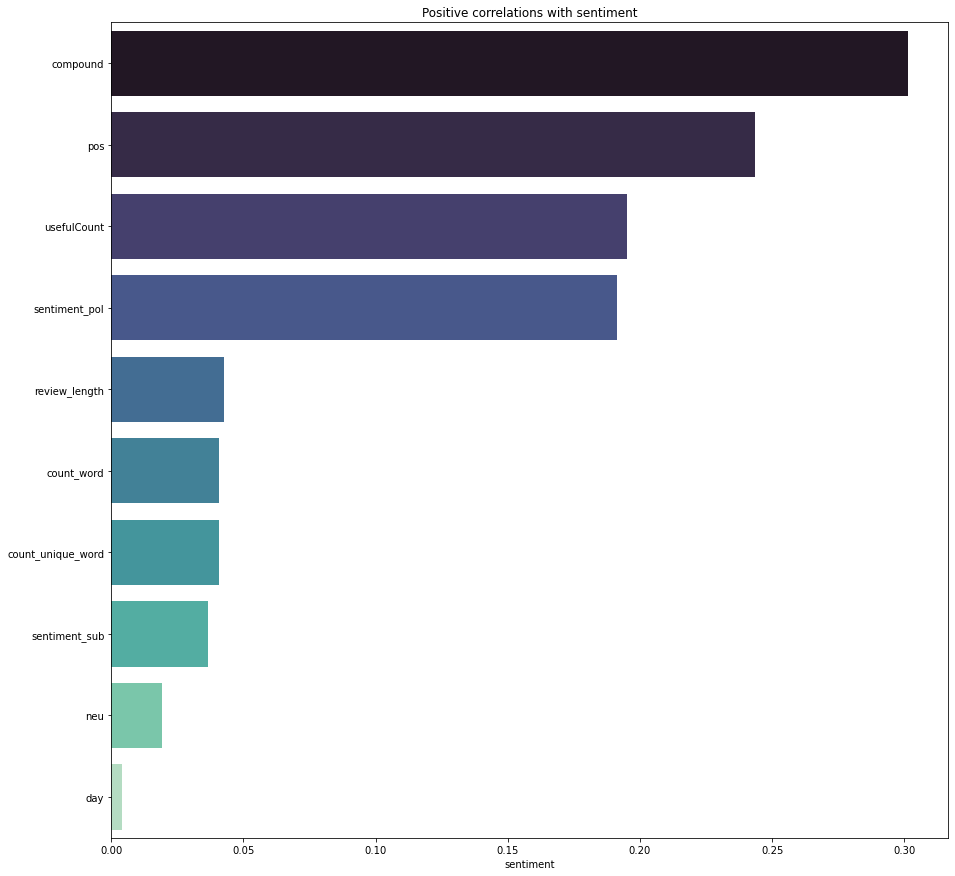

In [40]:
# positive correlations
pos_corrs = drugs_corrs[drugs_corrs['sentiment'] >= 0]
sns.barplot(x='sentiment', y=pos_corrs.index, data=pos_corrs, palette = 'mako')
plt.title('Positive correlations with sentiment')
plt.show()

# Traditional Machine Learning

## Sample

First of all, we take a sample of the dataset because we have too many observations.

In [41]:
# very little sample (problem --> when we vectorize we have more columns than rows)

drugs_sample2 = drugs_sent_int.sample(frac=0.05)
drugs_sample2.shape

(9231, 19)

In [234]:
# bigger sample to solve the problem

drugs_sample3 = drugs_sent_int.sample(frac=0.25)
drugs_sample3.shape

(46156, 19)

## Train test split

In [42]:
X2 = drugs_sample2.drop('sentiment', axis=1)
y2 = drugs_sample2['sentiment']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, shuffle=True, random_state=42)

In [452]:
X3 = drugs_sample3.drop('sentiment', axis=1)
y3 = drugs_sample3['sentiment']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, shuffle=True, random_state=42)

In [43]:
main_kfold = KFold(10, shuffle=True, random_state=42)

## Vectorize

Models don't work well with text, we need to convert text to vectors.

In [44]:
def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [46]:
tfidf_vect = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit=tfidf_vect.fit(X2_train['review'])
X2_train=vectorize(X2_train['review'],tfidf_vect_fit)

C:\Users\Cristina\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [453]:
tfidf_vect2 = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit2=tfidf_vect2.fit(X3_train['review'])
X3_train=vectorize(X3_train['review'],tfidf_vect_fit2)

C:\Users\Cristina\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [232]:
X2_train

,aa,aaand,aaps,ab,abacavir,abandon,abate,abatement,abc,abdomen,...,zoviraz,zubsolv,zyban,zyclara,zyprexa,zyrtec,zytiga,zytram,zyvox,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [454]:
X3_train

,aa,aaaaarg,aaaahhhhh,aaahh,aap,aaps,aarp,ab,abacavir,abacus,...,zylet,zyneret,zyprexa,zyrtec,zytiga,zyvox,zzquill,zzz,zzzquil,zzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Random Forest

In [47]:
rf = RandomForestClassifier()
scores = cross_val_score(rf,X2_train,y2_train.values.ravel(),cv=5)

In [48]:
print(scores)
scores.mean()

[0.77251185 0.77589709 0.77251185 0.76980366 0.77235772]


0.7726164330025155

In [82]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

In [83]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X2_train,y2_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 50}



In [80]:
# we try the best parameters 

rf2 = RandomForestClassifier(max_depth = None, n_estimators = 50)
scores2 = cross_val_score(rf2,X2_train,y2_train.values.ravel(),cv=5)

In [81]:
print(scores2)
scores2.mean()

[0.77251185 0.77454299 0.7718348  0.77657414 0.7798103 ]


0.7750548152062429

In [86]:
X2_test=vectorize(X2_test['review'],tfidf_vect_fit)

C:\Users\Cristina\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [87]:
rf1 = RandomForestClassifier(n_estimators=100,max_depth=20)
rf1.fit(X2_train, y2_train.values.ravel())
rf2 = RandomForestClassifier(n_estimators=100,max_depth=None)
rf2.fit(X2_train, y2_train.values.ravel())
rf3 = RandomForestClassifier(n_estimators=5,max_depth=None)
rf3.fit(X2_train, y2_train.values.ravel())

RandomForestClassifier(n_estimators=5)

In [89]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

for mdl in [rf1,rf2,rf3]:
    y_pred = mdl.predict(X2_test)
    accuracy = round(accuracy_score(y2_test,y_pred), 3)
    precision = round(precision_score(y2_test,y_pred), 3)
    recall = round(recall_score(y2_test,y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth,
                                                                         mdl.n_estimators,
                                                                         accuracy,
                                                                         precision,
                                                                         recall))

MAX DEPTH: 20 / # OF EST: 100 -- A: 0.769 / P: 0.769 / R: 1.0
MAX DEPTH: None / # OF EST: 100 -- A: 0.792 / P: 0.788 / R: 0.997
MAX DEPTH: None / # OF EST: 5 -- A: 0.768 / P: 0.802 / R: 0.927


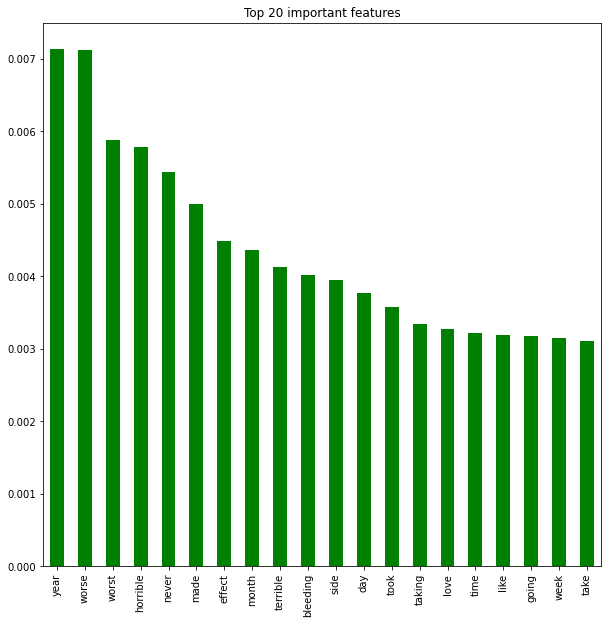

In [94]:
feat_importances = pd.Series(rf2.feature_importances_, index=X2_train.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10), color='green')
plt.title("Top 20 important features")
plt.show()

In [455]:
X3_test=vectorize(X3_test['review'],tfidf_vect_fit2)

C:\Users\Cristina\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [245]:
# using the bigger sample
#RF without parameter tunning

scores_3 = cross_val_score(rf,X3_train,y3_train.values.ravel(),cv=5)

In [247]:
# we try the best parameters we got before

rf_4 = RandomForestClassifier(n_estimators=100,max_depth=None)
rf_4.fit(X3_train, y3_train.values.ravel())

RandomForestClassifier()

In [248]:
scores_4 = cross_val_score(rf_4,X3_train,y3_train.values.ravel(),cv=5)
print(scores_4)
scores_4.mean()

[0.80081246 0.81096818 0.80148951 0.8028436  0.8037649 ]


0.8039757282301171

## LGBM

In [125]:
from lightgbm import LGBMModel,LGBMClassifier, plot_importance

clf = LGBMClassifier()

parameters = {
    'n_estimators' : [1000, 5000, 10000],
    'learning_rate': [0.1, 0.3],
    'num_leaves': [10, 30, 50],
    'objective' : ['binary'],
    'max_depth': [1, 2, 5, 10],
    'min_split_gain':[.01],
    'min_child_weight':[2],
    }

cv2 = GridSearchCV(clf,parameters)
cv2.fit(X2_train,y2_train.values.ravel())
print_results(cv2)

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'min_split_gain': 0.01, 'n_estimators': 1000, 'num_leaves': 10, 'objective': 'binary'}



In [126]:
clf2 = LGBMClassifier(learning_rate = 0.1, max_depth = 5, min_child_weight = 2, min_split_gain = 0.01, 
                      n_estimators = 1000, num_leaves = 10, objective = 'binary')

scores3 = cross_val_score(clf2,X2_train,y2_train.values.ravel(),cv=main_kfold)

In [127]:
print(scores3)
scores3.mean()

[0.79837618 0.79566982 0.797023   0.81596752 0.80623306 0.78861789
 0.83468835 0.82520325 0.8197832  0.83197832]


0.811354060089992

In [153]:
model1 = clf2.fit(X2_train, y2_train)

# Predictions
predictions1 = model1.predict(X2_test)
print ("The Accuracy of the model is : ", accuracy_score(y2_test, predictions1))
print ("The confusion Matrix is ")
confusion_matrix(y2_test, predictions1)

The Accuracy of the model is :  0.8191662154845696
The confusion Matrix is 


array([[ 200,  227],
       [ 107, 1313]], dtype=int64)

In [154]:
print (classification_report(y2_test, predictions1))

              precision    recall  f1-score   support

           0       0.65      0.47      0.54       427
           1       0.85      0.92      0.89      1420

    accuracy                           0.82      1847
   macro avg       0.75      0.70      0.72      1847
weighted avg       0.81      0.82      0.81      1847



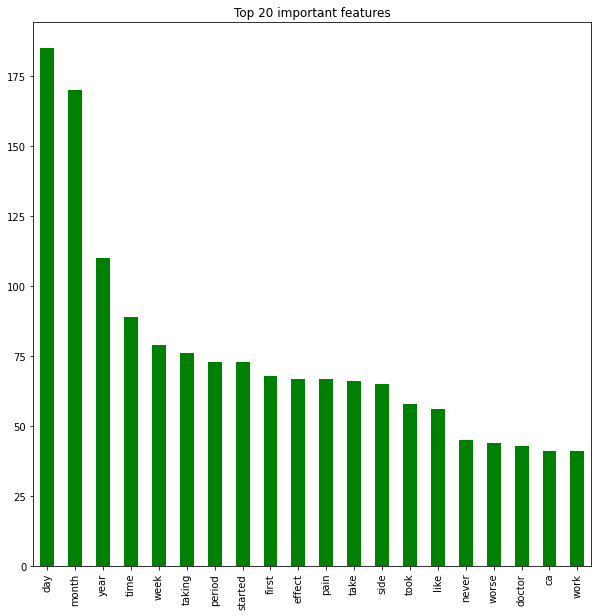

In [143]:
feat_importances = pd.Series(clf2.feature_importances_, index=X2_train.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10), color='green')
plt.title("Top 20 important features")
plt.show()

In [145]:
clf3 = LGBMClassifier(learning_rate = 0.1, max_depth = 7, min_split_gain = 0.01, 
                      n_estimators = 10000, num_leaves = 30, min_child_weight = 2,
                      reg_alpha=.1, reg_lambda=.1, verbose=-1)

scores4 = cross_val_score(clf3,X2_train,y2_train.values.ravel(),cv=main_kfold)

In [146]:
print(scores4)
scores4.mean()

[0.78078484 0.79431664 0.7902571  0.80920162 0.82655827 0.78861789
 0.8102981  0.82655827 0.8102981  0.82384824]


0.8060739078297413

In [155]:
model = clf3.fit(X2_train, y2_train)

# Predictions
predictions = model.predict(X2_test)
print ("The Accuracy of the model is : ", accuracy_score(y2_test, predictions))
print ("The confusion Matrix is ")
confusion_matrix(y2_test, predictions)

The Accuracy of the model is :  0.8245804006497022
The confusion Matrix is 


array([[ 213,  214],
       [ 110, 1310]], dtype=int64)

In [447]:
cf_lgbm = confusion_matrix(y2_test, predictions)

Text(0.5, 954.4, 'Predicted label')

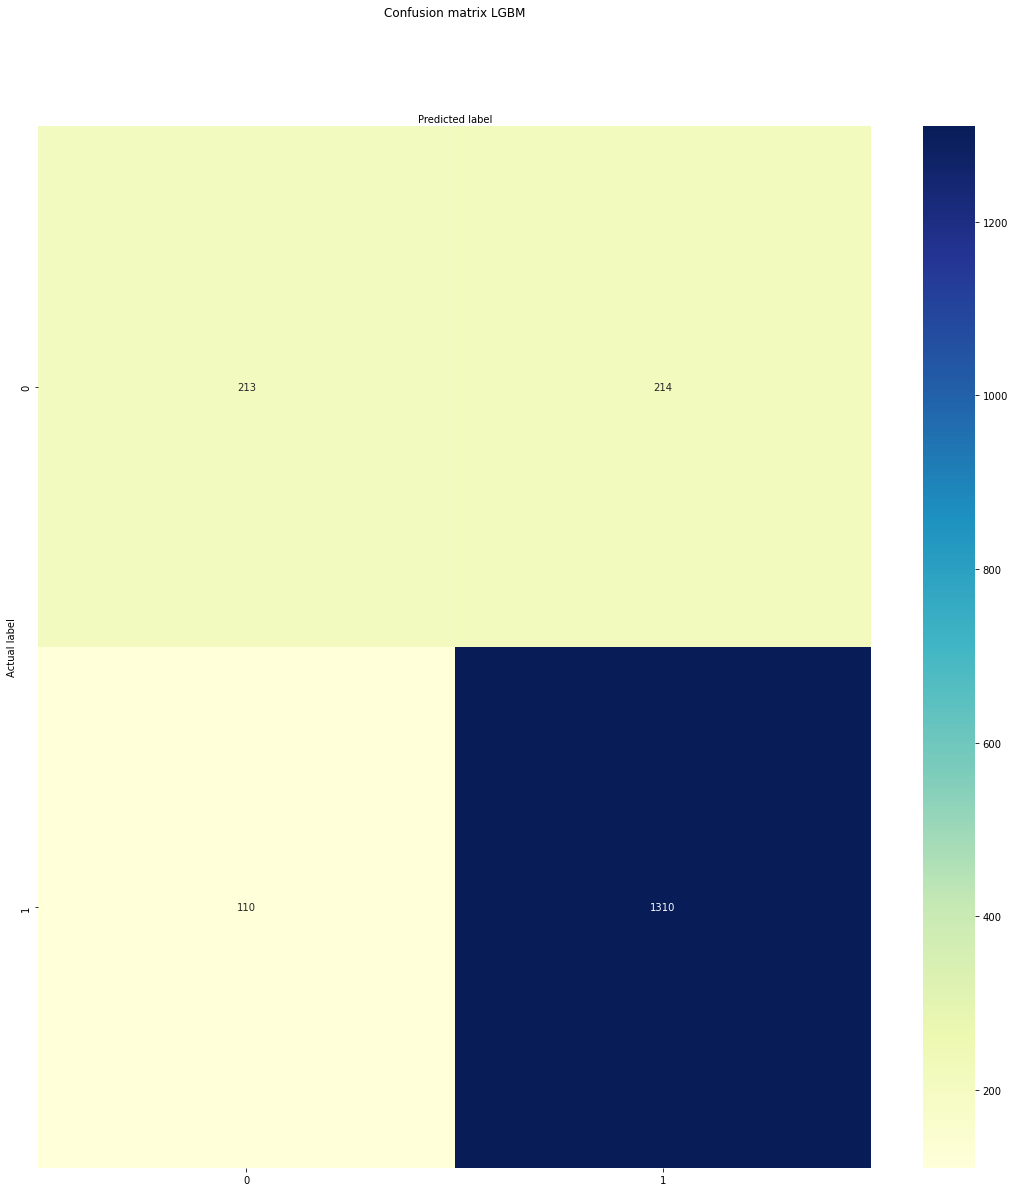

In [448]:
class_names=["class 0", "class 1"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cf_lgbm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix LGBM', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [156]:
print (classification_report(y2_test, predictions))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       427
           1       0.86      0.92      0.89      1420

    accuracy                           0.82      1847
   macro avg       0.76      0.71      0.73      1847
weighted avg       0.81      0.82      0.82      1847



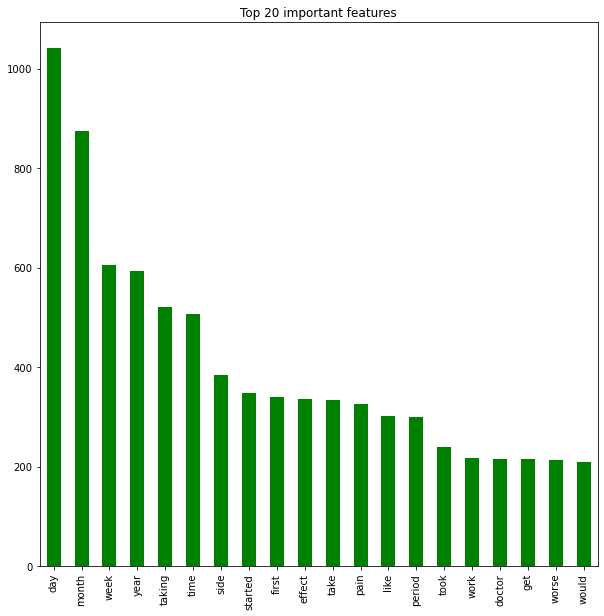

In [148]:
feat_importances = pd.Series(clf3.feature_importances_, index=X2_train.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10), color='green')
plt.title("Top 20 important features")
plt.show()

In [390]:
# With larger subset

scores5 = cross_val_score(clf3,X3_train,y3_train.values.ravel(),cv=main_kfold)
print(scores5)
scores5.mean()

[0.84348768 0.85973463 0.86515028 0.85269429 0.8556338  0.84994583
 0.85238353 0.8624052  0.85942579 0.84588299]


0.8546744023054362

In [456]:
model3 = clf3.fit(X3_train, y3_train)

# Predictions
predictions3 = model3.predict(X3_test)
print ("The Accuracy of the model is : ", accuracy_score(y3_test, predictions3))
print ("The confusion Matrix is ")
confusion_matrix(y3_test, predictions3)

The Accuracy of the model is :  0.8548526863084922
The confusion Matrix is 


array([[1387,  898],
       [ 442, 6505]], dtype=int64)

In [457]:
cm_lgbm = confusion_matrix(y3_test, predictions3) 

Text(0.5, 954.4, 'Predicted label')

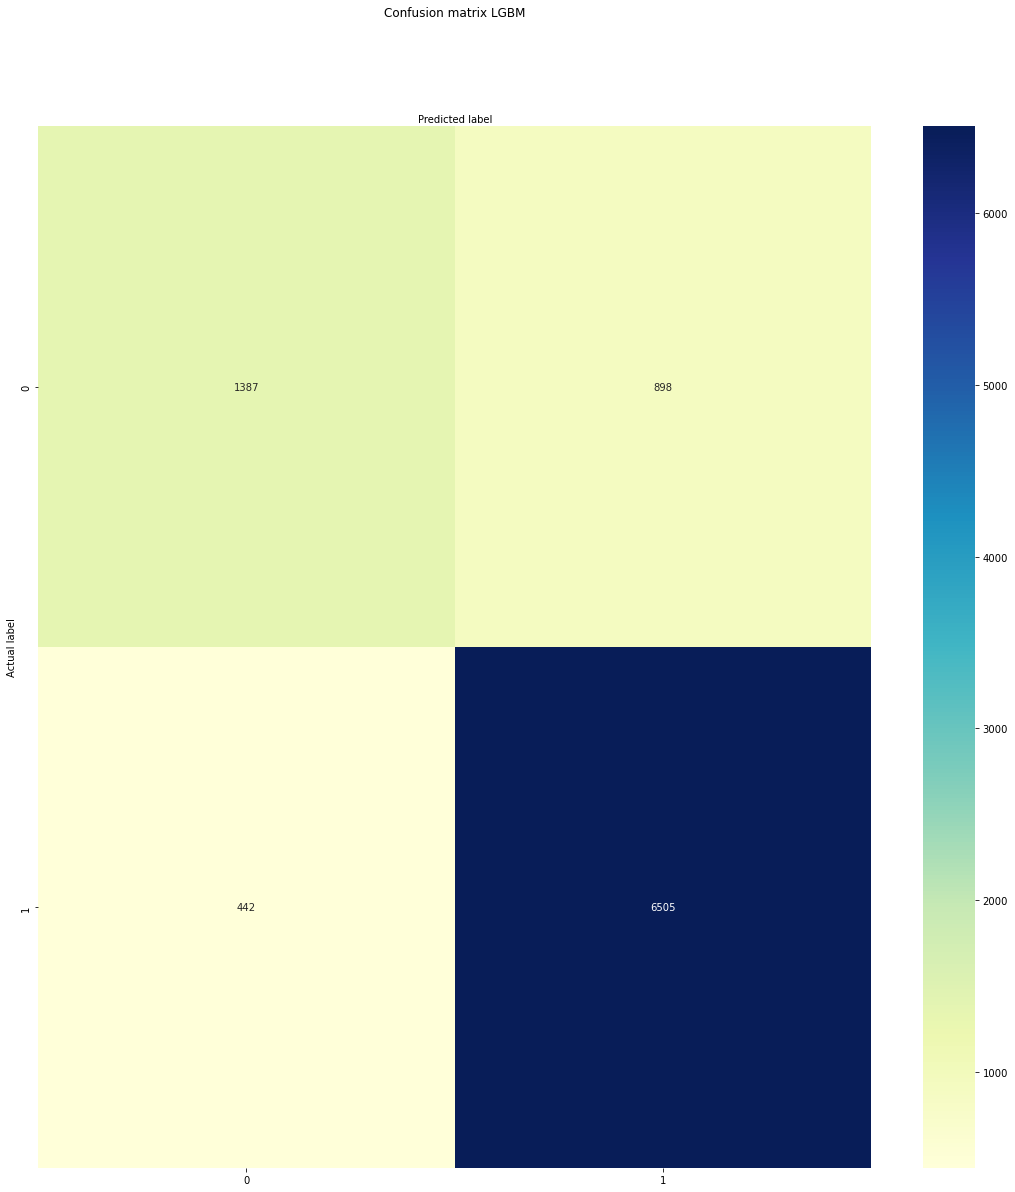

In [458]:
class_names=["class 0", "class 1"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm_lgbm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix LGBM', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

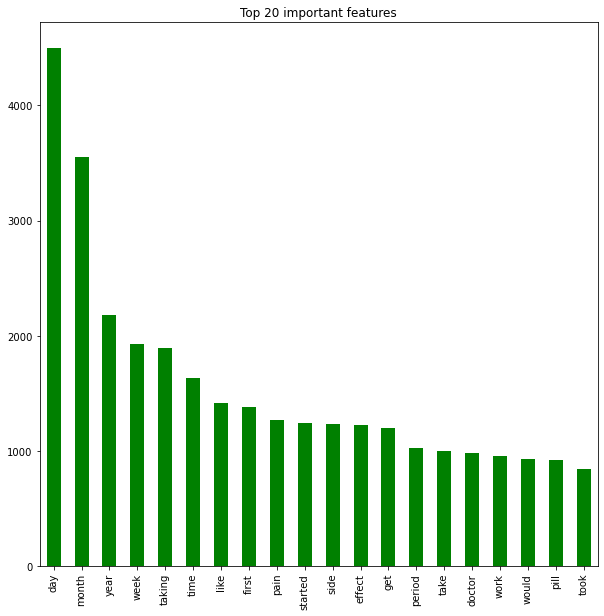

In [443]:
feat_importances = pd.Series(clf3.feature_importances_, index=X3_train.columns)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10), color='green')
plt.title("Top 20 important features")
plt.show()

## Cat Boost

In [160]:
# Training Model - III

cat_clf = CatBoostClassifier(iterations = 10000,
                            learning_rate = 0.5);

model_cat = cat_clf.fit(X2_train, y2_train);

0:	learn: 0.5874533	total: 332ms	remaining: 55m 18s
1:	learn: 0.5538941	total: 499ms	remaining: 41m 34s
2:	learn: 0.5370601	total: 669ms	remaining: 37m 9s
3:	learn: 0.5154767	total: 840ms	remaining: 35m
4:	learn: 0.5039782	total: 1.02s	remaining: 34m 2s
5:	learn: 0.4966425	total: 1.2s	remaining: 33m 20s
6:	learn: 0.4905431	total: 1.39s	remaining: 33m 3s
7:	learn: 0.4825932	total: 1.58s	remaining: 32m 56s
8:	learn: 0.4755762	total: 1.76s	remaining: 32m 33s
9:	learn: 0.4696489	total: 1.94s	remaining: 32m 14s
10:	learn: 0.4633395	total: 2.1s	remaining: 31m 51s
11:	learn: 0.4580426	total: 2.27s	remaining: 31m 34s
12:	learn: 0.4531445	total: 2.45s	remaining: 31m 22s
13:	learn: 0.4479285	total: 2.65s	remaining: 31m 28s
14:	learn: 0.4434241	total: 2.84s	remaining: 31m 30s
15:	learn: 0.4376364	total: 3.06s	remaining: 31m 50s
16:	learn: 0.4323596	total: 3.25s	remaining: 31m 51s
17:	learn: 0.4264890	total: 3.45s	remaining: 31m 51s
18:	learn: 0.4207601	total: 3.62s	remaining: 31m 42s
19:	learn: 0

157:	learn: 0.1617048	total: 27.6s	remaining: 28m 39s
158:	learn: 0.1613330	total: 27.8s	remaining: 28m 39s
159:	learn: 0.1603643	total: 28s	remaining: 28m 39s
160:	learn: 0.1600133	total: 28.1s	remaining: 28m 38s
161:	learn: 0.1595422	total: 28.3s	remaining: 28m 38s
162:	learn: 0.1586118	total: 28.5s	remaining: 28m 38s
163:	learn: 0.1581209	total: 28.7s	remaining: 28m 39s
164:	learn: 0.1569361	total: 28.8s	remaining: 28m 39s
165:	learn: 0.1556550	total: 29s	remaining: 28m 39s
166:	learn: 0.1552558	total: 29.2s	remaining: 28m 38s
167:	learn: 0.1542789	total: 29.4s	remaining: 28m 38s
168:	learn: 0.1538338	total: 29.6s	remaining: 28m 39s
169:	learn: 0.1528043	total: 29.7s	remaining: 28m 38s
170:	learn: 0.1515935	total: 29.9s	remaining: 28m 40s
171:	learn: 0.1512694	total: 30.1s	remaining: 28m 39s
172:	learn: 0.1508340	total: 30.3s	remaining: 28m 39s
173:	learn: 0.1497634	total: 30.4s	remaining: 28m 39s
174:	learn: 0.1494714	total: 30.6s	remaining: 28m 39s
175:	learn: 0.1480032	total: 30.

311:	learn: 0.0834272	total: 54.1s	remaining: 28m
312:	learn: 0.0826604	total: 54.3s	remaining: 28m
313:	learn: 0.0825268	total: 54.5s	remaining: 27m 59s
314:	learn: 0.0823509	total: 54.6s	remaining: 27m 59s
315:	learn: 0.0820201	total: 54.8s	remaining: 27m 59s
316:	learn: 0.0818469	total: 55s	remaining: 27m 58s
317:	learn: 0.0817343	total: 55.1s	remaining: 27m 58s
318:	learn: 0.0815787	total: 55.3s	remaining: 27m 57s
319:	learn: 0.0809655	total: 55.5s	remaining: 27m 57s
320:	learn: 0.0807389	total: 55.6s	remaining: 27m 57s
321:	learn: 0.0803117	total: 55.8s	remaining: 27m 56s
322:	learn: 0.0799450	total: 56s	remaining: 27m 56s
323:	learn: 0.0797459	total: 56.1s	remaining: 27m 56s
324:	learn: 0.0791768	total: 56.3s	remaining: 27m 55s
325:	learn: 0.0787921	total: 56.5s	remaining: 27m 55s
326:	learn: 0.0786827	total: 56.6s	remaining: 27m 54s
327:	learn: 0.0780147	total: 56.8s	remaining: 27m 54s
328:	learn: 0.0774382	total: 57s	remaining: 27m 54s
329:	learn: 0.0768505	total: 57.1s	remaini

464:	learn: 0.0505024	total: 1m 20s	remaining: 27m 23s
465:	learn: 0.0502582	total: 1m 20s	remaining: 27m 23s
466:	learn: 0.0498796	total: 1m 20s	remaining: 27m 23s
467:	learn: 0.0497825	total: 1m 20s	remaining: 27m 23s
468:	learn: 0.0496803	total: 1m 20s	remaining: 27m 22s
469:	learn: 0.0495347	total: 1m 21s	remaining: 27m 22s
470:	learn: 0.0494885	total: 1m 21s	remaining: 27m 22s
471:	learn: 0.0494425	total: 1m 21s	remaining: 27m 22s
472:	learn: 0.0491748	total: 1m 21s	remaining: 27m 21s
473:	learn: 0.0490153	total: 1m 21s	remaining: 27m 21s
474:	learn: 0.0489697	total: 1m 21s	remaining: 27m 21s
475:	learn: 0.0488927	total: 1m 22s	remaining: 27m 21s
476:	learn: 0.0485813	total: 1m 22s	remaining: 27m 22s
477:	learn: 0.0484393	total: 1m 22s	remaining: 27m 22s
478:	learn: 0.0481302	total: 1m 22s	remaining: 27m 22s
479:	learn: 0.0477954	total: 1m 22s	remaining: 27m 22s
480:	learn: 0.0477288	total: 1m 23s	remaining: 27m 22s
481:	learn: 0.0474722	total: 1m 23s	remaining: 27m 22s
482:	learn

614:	learn: 0.0333756	total: 1m 48s	remaining: 27m 33s
615:	learn: 0.0332058	total: 1m 48s	remaining: 27m 34s
616:	learn: 0.0330621	total: 1m 48s	remaining: 27m 34s
617:	learn: 0.0329519	total: 1m 48s	remaining: 27m 34s
618:	learn: 0.0329035	total: 1m 49s	remaining: 27m 34s
619:	learn: 0.0328279	total: 1m 49s	remaining: 27m 34s
620:	learn: 0.0326836	total: 1m 49s	remaining: 27m 34s
621:	learn: 0.0326489	total: 1m 49s	remaining: 27m 33s
622:	learn: 0.0326066	total: 1m 49s	remaining: 27m 33s
623:	learn: 0.0324462	total: 1m 50s	remaining: 27m 33s
624:	learn: 0.0324118	total: 1m 50s	remaining: 27m 33s
625:	learn: 0.0322708	total: 1m 50s	remaining: 27m 33s
626:	learn: 0.0322406	total: 1m 50s	remaining: 27m 33s
627:	learn: 0.0322177	total: 1m 50s	remaining: 27m 33s
628:	learn: 0.0321817	total: 1m 51s	remaining: 27m 34s
629:	learn: 0.0320512	total: 1m 51s	remaining: 27m 35s
630:	learn: 0.0320017	total: 1m 51s	remaining: 27m 35s
631:	learn: 0.0319783	total: 1m 51s	remaining: 27m 36s
632:	learn

766:	learn: 0.0245213	total: 2m 15s	remaining: 27m 10s
767:	learn: 0.0244986	total: 2m 15s	remaining: 27m 10s
768:	learn: 0.0243936	total: 2m 15s	remaining: 27m 10s
769:	learn: 0.0243611	total: 2m 15s	remaining: 27m 9s
770:	learn: 0.0242815	total: 2m 16s	remaining: 27m 9s
771:	learn: 0.0241810	total: 2m 16s	remaining: 27m 9s
772:	learn: 0.0241679	total: 2m 16s	remaining: 27m 8s
773:	learn: 0.0240508	total: 2m 16s	remaining: 27m 8s
774:	learn: 0.0240321	total: 2m 16s	remaining: 27m 8s
775:	learn: 0.0240194	total: 2m 16s	remaining: 27m 7s
776:	learn: 0.0238959	total: 2m 17s	remaining: 27m 7s
777:	learn: 0.0238779	total: 2m 17s	remaining: 27m 7s
778:	learn: 0.0238652	total: 2m 17s	remaining: 27m 7s
779:	learn: 0.0237504	total: 2m 17s	remaining: 27m 6s
780:	learn: 0.0237503	total: 2m 17s	remaining: 27m 6s
781:	learn: 0.0236260	total: 2m 17s	remaining: 27m 6s
782:	learn: 0.0236215	total: 2m 18s	remaining: 27m 6s
783:	learn: 0.0235373	total: 2m 18s	remaining: 27m 6s
784:	learn: 0.0234880	tot

918:	learn: 0.0191297	total: 2m 43s	remaining: 26m 55s
919:	learn: 0.0191156	total: 2m 43s	remaining: 26m 55s
920:	learn: 0.0190992	total: 2m 43s	remaining: 26m 55s
921:	learn: 0.0190975	total: 2m 44s	remaining: 26m 54s
922:	learn: 0.0190918	total: 2m 44s	remaining: 26m 54s
923:	learn: 0.0190685	total: 2m 44s	remaining: 26m 54s
924:	learn: 0.0190408	total: 2m 44s	remaining: 26m 53s
925:	learn: 0.0190406	total: 2m 44s	remaining: 26m 53s
926:	learn: 0.0189801	total: 2m 44s	remaining: 26m 53s
927:	learn: 0.0189651	total: 2m 44s	remaining: 26m 52s
928:	learn: 0.0189403	total: 2m 45s	remaining: 26m 52s
929:	learn: 0.0189333	total: 2m 45s	remaining: 26m 52s
930:	learn: 0.0189332	total: 2m 45s	remaining: 26m 52s
931:	learn: 0.0188622	total: 2m 45s	remaining: 26m 52s
932:	learn: 0.0188182	total: 2m 45s	remaining: 26m 51s
933:	learn: 0.0188033	total: 2m 46s	remaining: 26m 51s
934:	learn: 0.0188014	total: 2m 46s	remaining: 26m 51s
935:	learn: 0.0188013	total: 2m 46s	remaining: 26m 51s
936:	learn

1068:	learn: 0.0160014	total: 3m 9s	remaining: 26m 24s
1069:	learn: 0.0160013	total: 3m 9s	remaining: 26m 25s
1070:	learn: 0.0158904	total: 3m 10s	remaining: 26m 25s
1071:	learn: 0.0158813	total: 3m 10s	remaining: 26m 25s
1072:	learn: 0.0158796	total: 3m 10s	remaining: 26m 26s
1073:	learn: 0.0158736	total: 3m 10s	remaining: 26m 26s
1074:	learn: 0.0158694	total: 3m 11s	remaining: 26m 26s
1075:	learn: 0.0158601	total: 3m 11s	remaining: 26m 26s
1076:	learn: 0.0158592	total: 3m 11s	remaining: 26m 26s
1077:	learn: 0.0157798	total: 3m 11s	remaining: 26m 26s
1078:	learn: 0.0157798	total: 3m 11s	remaining: 26m 25s
1079:	learn: 0.0157757	total: 3m 11s	remaining: 26m 25s
1080:	learn: 0.0157581	total: 3m 12s	remaining: 26m 25s
1081:	learn: 0.0157346	total: 3m 12s	remaining: 26m 25s
1082:	learn: 0.0157259	total: 3m 12s	remaining: 26m 24s
1083:	learn: 0.0157137	total: 3m 12s	remaining: 26m 24s
1084:	learn: 0.0157025	total: 3m 12s	remaining: 26m 24s
1085:	learn: 0.0157024	total: 3m 12s	remaining: 26

1216:	learn: 0.0140722	total: 3m 37s	remaining: 26m 9s
1217:	learn: 0.0140716	total: 3m 37s	remaining: 26m 8s
1218:	learn: 0.0140634	total: 3m 37s	remaining: 26m 8s
1219:	learn: 0.0140572	total: 3m 37s	remaining: 26m 8s
1220:	learn: 0.0140571	total: 3m 38s	remaining: 26m 7s
1221:	learn: 0.0140527	total: 3m 38s	remaining: 26m 7s
1222:	learn: 0.0140381	total: 3m 38s	remaining: 26m 7s
1223:	learn: 0.0140381	total: 3m 38s	remaining: 26m 7s
1224:	learn: 0.0140102	total: 3m 38s	remaining: 26m 6s
1225:	learn: 0.0140100	total: 3m 38s	remaining: 26m 6s
1226:	learn: 0.0140099	total: 3m 39s	remaining: 26m 6s
1227:	learn: 0.0140098	total: 3m 39s	remaining: 26m 6s
1228:	learn: 0.0140098	total: 3m 39s	remaining: 26m 5s
1229:	learn: 0.0140098	total: 3m 39s	remaining: 26m 5s
1230:	learn: 0.0140097	total: 3m 39s	remaining: 26m 5s
1231:	learn: 0.0140055	total: 3m 39s	remaining: 26m 5s
1232:	learn: 0.0140054	total: 3m 40s	remaining: 26m 4s
1233:	learn: 0.0140054	total: 3m 40s	remaining: 26m 4s
1234:	lear

1365:	learn: 0.0128637	total: 4m 3s	remaining: 25m 39s
1366:	learn: 0.0128352	total: 4m 3s	remaining: 25m 39s
1367:	learn: 0.0128352	total: 4m 4s	remaining: 25m 39s
1368:	learn: 0.0128333	total: 4m 4s	remaining: 25m 39s
1369:	learn: 0.0128331	total: 4m 4s	remaining: 25m 39s
1370:	learn: 0.0128330	total: 4m 4s	remaining: 25m 38s
1371:	learn: 0.0128314	total: 4m 4s	remaining: 25m 38s
1372:	learn: 0.0128312	total: 4m 4s	remaining: 25m 38s
1373:	learn: 0.0128307	total: 4m 5s	remaining: 25m 38s
1374:	learn: 0.0128043	total: 4m 5s	remaining: 25m 38s
1375:	learn: 0.0127942	total: 4m 5s	remaining: 25m 37s
1376:	learn: 0.0127937	total: 4m 5s	remaining: 25m 37s
1377:	learn: 0.0127929	total: 4m 5s	remaining: 25m 37s
1378:	learn: 0.0127894	total: 4m 5s	remaining: 25m 37s
1379:	learn: 0.0127894	total: 4m 6s	remaining: 25m 36s
1380:	learn: 0.0127188	total: 4m 6s	remaining: 25m 36s
1381:	learn: 0.0127180	total: 4m 6s	remaining: 25m 36s
1382:	learn: 0.0127180	total: 4m 6s	remaining: 25m 35s
1383:	lear

1512:	learn: 0.0122157	total: 4m 32s	remaining: 25m 27s
1513:	learn: 0.0122152	total: 4m 32s	remaining: 25m 26s
1514:	learn: 0.0122152	total: 4m 32s	remaining: 25m 26s
1515:	learn: 0.0122152	total: 4m 32s	remaining: 25m 26s
1516:	learn: 0.0122150	total: 4m 32s	remaining: 25m 26s
1517:	learn: 0.0122090	total: 4m 33s	remaining: 25m 25s
1518:	learn: 0.0122088	total: 4m 33s	remaining: 25m 25s
1519:	learn: 0.0122088	total: 4m 33s	remaining: 25m 25s
1520:	learn: 0.0122088	total: 4m 33s	remaining: 25m 25s
1521:	learn: 0.0122078	total: 4m 33s	remaining: 25m 24s
1522:	learn: 0.0122046	total: 4m 33s	remaining: 25m 24s
1523:	learn: 0.0121766	total: 4m 34s	remaining: 25m 24s
1524:	learn: 0.0121765	total: 4m 34s	remaining: 25m 23s
1525:	learn: 0.0121758	total: 4m 34s	remaining: 25m 23s
1526:	learn: 0.0121746	total: 4m 34s	remaining: 25m 23s
1527:	learn: 0.0121743	total: 4m 34s	remaining: 25m 23s
1528:	learn: 0.0121736	total: 4m 34s	remaining: 25m 23s
1529:	learn: 0.0121728	total: 4m 35s	remaining: 

1661:	learn: 0.0116560	total: 4m 57s	remaining: 24m 53s
1662:	learn: 0.0116558	total: 4m 57s	remaining: 24m 52s
1663:	learn: 0.0116557	total: 4m 57s	remaining: 24m 52s
1664:	learn: 0.0116529	total: 4m 58s	remaining: 24m 52s
1665:	learn: 0.0116513	total: 4m 58s	remaining: 24m 52s
1666:	learn: 0.0116512	total: 4m 58s	remaining: 24m 51s
1667:	learn: 0.0116485	total: 4m 58s	remaining: 24m 51s
1668:	learn: 0.0116436	total: 4m 58s	remaining: 24m 51s
1669:	learn: 0.0116435	total: 4m 58s	remaining: 24m 51s
1670:	learn: 0.0116435	total: 4m 59s	remaining: 24m 51s
1671:	learn: 0.0116433	total: 4m 59s	remaining: 24m 50s
1672:	learn: 0.0116349	total: 4m 59s	remaining: 24m 50s
1673:	learn: 0.0116348	total: 4m 59s	remaining: 24m 50s
1674:	learn: 0.0116348	total: 4m 59s	remaining: 24m 50s
1675:	learn: 0.0116258	total: 4m 59s	remaining: 24m 49s
1676:	learn: 0.0116255	total: 5m	remaining: 24m 49s
1677:	learn: 0.0116255	total: 5m	remaining: 24m 49s
1678:	learn: 0.0116227	total: 5m	remaining: 24m 49s
1679

1809:	learn: 0.0111021	total: 5m 22s	remaining: 24m 18s
1810:	learn: 0.0111015	total: 5m 22s	remaining: 24m 18s
1811:	learn: 0.0111007	total: 5m 22s	remaining: 24m 17s
1812:	learn: 0.0110961	total: 5m 22s	remaining: 24m 17s
1813:	learn: 0.0110576	total: 5m 22s	remaining: 24m 17s
1814:	learn: 0.0110566	total: 5m 23s	remaining: 24m 17s
1815:	learn: 0.0110291	total: 5m 23s	remaining: 24m 17s
1816:	learn: 0.0110289	total: 5m 23s	remaining: 24m 16s
1817:	learn: 0.0110288	total: 5m 23s	remaining: 24m 16s
1818:	learn: 0.0110261	total: 5m 23s	remaining: 24m 16s
1819:	learn: 0.0110261	total: 5m 23s	remaining: 24m 16s
1820:	learn: 0.0110256	total: 5m 24s	remaining: 24m 15s
1821:	learn: 0.0110189	total: 5m 24s	remaining: 24m 15s
1822:	learn: 0.0110176	total: 5m 24s	remaining: 24m 15s
1823:	learn: 0.0110162	total: 5m 24s	remaining: 24m 15s
1824:	learn: 0.0110150	total: 5m 24s	remaining: 24m 15s
1825:	learn: 0.0109925	total: 5m 25s	remaining: 24m 14s
1826:	learn: 0.0109919	total: 5m 25s	remaining: 

1957:	learn: 0.0105418	total: 5m 47s	remaining: 23m 47s
1958:	learn: 0.0105356	total: 5m 47s	remaining: 23m 46s
1959:	learn: 0.0105301	total: 5m 47s	remaining: 23m 46s
1960:	learn: 0.0105072	total: 5m 47s	remaining: 23m 46s
1961:	learn: 0.0105065	total: 5m 48s	remaining: 23m 46s
1962:	learn: 0.0105047	total: 5m 48s	remaining: 23m 45s
1963:	learn: 0.0105044	total: 5m 48s	remaining: 23m 45s
1964:	learn: 0.0105001	total: 5m 48s	remaining: 23m 45s
1965:	learn: 0.0104988	total: 5m 48s	remaining: 23m 45s
1966:	learn: 0.0104926	total: 5m 48s	remaining: 23m 45s
1967:	learn: 0.0104716	total: 5m 49s	remaining: 23m 44s
1968:	learn: 0.0104680	total: 5m 49s	remaining: 23m 44s
1969:	learn: 0.0104675	total: 5m 49s	remaining: 23m 44s
1970:	learn: 0.0104672	total: 5m 49s	remaining: 23m 44s
1971:	learn: 0.0104636	total: 5m 49s	remaining: 23m 43s
1972:	learn: 0.0104456	total: 5m 49s	remaining: 23m 43s
1973:	learn: 0.0104456	total: 5m 50s	remaining: 23m 43s
1974:	learn: 0.0104447	total: 5m 50s	remaining: 

2105:	learn: 0.0101137	total: 6m 12s	remaining: 23m 14s
2106:	learn: 0.0100836	total: 6m 12s	remaining: 23m 14s
2107:	learn: 0.0100834	total: 6m 12s	remaining: 23m 14s
2108:	learn: 0.0100830	total: 6m 12s	remaining: 23m 14s
2109:	learn: 0.0100822	total: 6m 12s	remaining: 23m 13s
2110:	learn: 0.0100821	total: 6m 12s	remaining: 23m 13s
2111:	learn: 0.0100815	total: 6m 13s	remaining: 23m 13s
2112:	learn: 0.0100814	total: 6m 13s	remaining: 23m 13s
2113:	learn: 0.0100809	total: 6m 13s	remaining: 23m 12s
2114:	learn: 0.0100807	total: 6m 13s	remaining: 23m 12s
2115:	learn: 0.0100806	total: 6m 13s	remaining: 23m 12s
2116:	learn: 0.0100790	total: 6m 13s	remaining: 23m 12s
2117:	learn: 0.0100789	total: 6m 14s	remaining: 23m 12s
2118:	learn: 0.0100782	total: 6m 14s	remaining: 23m 11s
2119:	learn: 0.0100782	total: 6m 14s	remaining: 23m 11s
2120:	learn: 0.0100778	total: 6m 14s	remaining: 23m 11s
2121:	learn: 0.0100778	total: 6m 14s	remaining: 23m 11s
2122:	learn: 0.0100760	total: 6m 14s	remaining: 

2253:	learn: 0.0097918	total: 6m 36s	remaining: 22m 43s
2254:	learn: 0.0097918	total: 6m 36s	remaining: 22m 43s
2255:	learn: 0.0097865	total: 6m 37s	remaining: 22m 42s
2256:	learn: 0.0097865	total: 6m 37s	remaining: 22m 42s
2257:	learn: 0.0097597	total: 6m 37s	remaining: 22m 42s
2258:	learn: 0.0097597	total: 6m 37s	remaining: 22m 42s
2259:	learn: 0.0097595	total: 6m 37s	remaining: 22m 41s
2260:	learn: 0.0097594	total: 6m 37s	remaining: 22m 41s
2261:	learn: 0.0097593	total: 6m 38s	remaining: 22m 41s
2262:	learn: 0.0097593	total: 6m 38s	remaining: 22m 41s
2263:	learn: 0.0097593	total: 6m 38s	remaining: 22m 41s
2264:	learn: 0.0097593	total: 6m 38s	remaining: 22m 40s
2265:	learn: 0.0097591	total: 6m 38s	remaining: 22m 40s
2266:	learn: 0.0097588	total: 6m 38s	remaining: 22m 40s
2267:	learn: 0.0097587	total: 6m 39s	remaining: 22m 40s
2268:	learn: 0.0097583	total: 6m 39s	remaining: 22m 40s
2269:	learn: 0.0097567	total: 6m 39s	remaining: 22m 39s
2270:	learn: 0.0097557	total: 6m 39s	remaining: 

2401:	learn: 0.0095817	total: 7m 1s	remaining: 22m 12s
2402:	learn: 0.0095814	total: 7m 1s	remaining: 22m 12s
2403:	learn: 0.0095812	total: 7m 1s	remaining: 22m 12s
2404:	learn: 0.0095812	total: 7m 1s	remaining: 22m 11s
2405:	learn: 0.0095811	total: 7m 1s	remaining: 22m 11s
2406:	learn: 0.0095810	total: 7m 2s	remaining: 22m 11s
2407:	learn: 0.0095804	total: 7m 2s	remaining: 22m 11s
2408:	learn: 0.0095803	total: 7m 2s	remaining: 22m 11s
2409:	learn: 0.0095803	total: 7m 2s	remaining: 22m 10s
2410:	learn: 0.0095802	total: 7m 2s	remaining: 22m 10s
2411:	learn: 0.0095802	total: 7m 2s	remaining: 22m 10s
2412:	learn: 0.0095801	total: 7m 3s	remaining: 22m 10s
2413:	learn: 0.0095799	total: 7m 3s	remaining: 22m 10s
2414:	learn: 0.0095758	total: 7m 3s	remaining: 22m 9s
2415:	learn: 0.0095745	total: 7m 3s	remaining: 22m 9s
2416:	learn: 0.0095745	total: 7m 3s	remaining: 22m 9s
2417:	learn: 0.0095740	total: 7m 3s	remaining: 22m 9s
2418:	learn: 0.0095682	total: 7m 4s	remaining: 22m 9s
2419:	learn: 0.

2551:	learn: 0.0093138	total: 7m 26s	remaining: 21m 42s
2552:	learn: 0.0093137	total: 7m 26s	remaining: 21m 42s
2553:	learn: 0.0093133	total: 7m 26s	remaining: 21m 41s
2554:	learn: 0.0093133	total: 7m 26s	remaining: 21m 41s
2555:	learn: 0.0093130	total: 7m 26s	remaining: 21m 41s
2556:	learn: 0.0093130	total: 7m 27s	remaining: 21m 41s
2557:	learn: 0.0093130	total: 7m 27s	remaining: 21m 41s
2558:	learn: 0.0093059	total: 7m 27s	remaining: 21m 40s
2559:	learn: 0.0093059	total: 7m 27s	remaining: 21m 40s
2560:	learn: 0.0093058	total: 7m 27s	remaining: 21m 40s
2561:	learn: 0.0093055	total: 7m 27s	remaining: 21m 40s
2562:	learn: 0.0093055	total: 7m 28s	remaining: 21m 40s
2563:	learn: 0.0093054	total: 7m 28s	remaining: 21m 39s
2564:	learn: 0.0093053	total: 7m 28s	remaining: 21m 39s
2565:	learn: 0.0093050	total: 7m 28s	remaining: 21m 39s
2566:	learn: 0.0093043	total: 7m 28s	remaining: 21m 39s
2567:	learn: 0.0093041	total: 7m 28s	remaining: 21m 39s
2568:	learn: 0.0093039	total: 7m 29s	remaining: 

2699:	learn: 0.0091846	total: 7m 50s	remaining: 21m 13s
2700:	learn: 0.0091815	total: 7m 51s	remaining: 21m 13s
2701:	learn: 0.0091711	total: 7m 51s	remaining: 21m 12s
2702:	learn: 0.0091711	total: 7m 51s	remaining: 21m 12s
2703:	learn: 0.0091708	total: 7m 51s	remaining: 21m 12s
2704:	learn: 0.0091708	total: 7m 51s	remaining: 21m 12s
2705:	learn: 0.0091511	total: 7m 51s	remaining: 21m 12s
2706:	learn: 0.0091485	total: 7m 52s	remaining: 21m 11s
2707:	learn: 0.0091485	total: 7m 52s	remaining: 21m 11s
2708:	learn: 0.0091481	total: 7m 52s	remaining: 21m 11s
2709:	learn: 0.0091480	total: 7m 52s	remaining: 21m 11s
2710:	learn: 0.0091478	total: 7m 52s	remaining: 21m 11s
2711:	learn: 0.0091477	total: 7m 52s	remaining: 21m 10s
2712:	learn: 0.0091472	total: 7m 53s	remaining: 21m 10s
2713:	learn: 0.0091469	total: 7m 53s	remaining: 21m 10s
2714:	learn: 0.0091469	total: 7m 53s	remaining: 21m 10s
2715:	learn: 0.0091468	total: 7m 53s	remaining: 21m 10s
2716:	learn: 0.0091465	total: 7m 53s	remaining: 

2849:	learn: 0.0089815	total: 8m 15s	remaining: 20m 44s
2850:	learn: 0.0089813	total: 8m 16s	remaining: 20m 43s
2851:	learn: 0.0089809	total: 8m 16s	remaining: 20m 43s
2852:	learn: 0.0089808	total: 8m 16s	remaining: 20m 43s
2853:	learn: 0.0089528	total: 8m 16s	remaining: 20m 43s
2854:	learn: 0.0089528	total: 8m 16s	remaining: 20m 43s
2855:	learn: 0.0089526	total: 8m 16s	remaining: 20m 42s
2856:	learn: 0.0089522	total: 8m 17s	remaining: 20m 42s
2857:	learn: 0.0089522	total: 8m 17s	remaining: 20m 42s
2858:	learn: 0.0089517	total: 8m 17s	remaining: 20m 42s
2859:	learn: 0.0089514	total: 8m 17s	remaining: 20m 42s
2860:	learn: 0.0089512	total: 8m 17s	remaining: 20m 41s
2861:	learn: 0.0089510	total: 8m 17s	remaining: 20m 41s
2862:	learn: 0.0089490	total: 8m 18s	remaining: 20m 41s
2863:	learn: 0.0089490	total: 8m 18s	remaining: 20m 41s
2864:	learn: 0.0089487	total: 8m 18s	remaining: 20m 41s
2865:	learn: 0.0089485	total: 8m 18s	remaining: 20m 41s
2866:	learn: 0.0089483	total: 8m 18s	remaining: 

2997:	learn: 0.0088173	total: 8m 40s	remaining: 20m 15s
2998:	learn: 0.0088172	total: 8m 40s	remaining: 20m 15s
2999:	learn: 0.0088168	total: 8m 40s	remaining: 20m 15s
3000:	learn: 0.0088165	total: 8m 40s	remaining: 20m 15s
3001:	learn: 0.0088162	total: 8m 41s	remaining: 20m 14s
3002:	learn: 0.0088160	total: 8m 41s	remaining: 20m 14s
3003:	learn: 0.0088158	total: 8m 41s	remaining: 20m 14s
3004:	learn: 0.0088154	total: 8m 41s	remaining: 20m 14s
3005:	learn: 0.0088150	total: 8m 41s	remaining: 20m 14s
3006:	learn: 0.0088071	total: 8m 42s	remaining: 20m 14s
3007:	learn: 0.0088059	total: 8m 42s	remaining: 20m 13s
3008:	learn: 0.0088059	total: 8m 42s	remaining: 20m 13s
3009:	learn: 0.0088056	total: 8m 42s	remaining: 20m 13s
3010:	learn: 0.0088050	total: 8m 42s	remaining: 20m 13s
3011:	learn: 0.0087922	total: 8m 43s	remaining: 20m 13s
3012:	learn: 0.0087911	total: 8m 43s	remaining: 20m 13s
3013:	learn: 0.0087891	total: 8m 43s	remaining: 20m 13s
3014:	learn: 0.0087891	total: 8m 43s	remaining: 

3146:	learn: 0.0086122	total: 9m 5s	remaining: 19m 48s
3147:	learn: 0.0086122	total: 9m 5s	remaining: 19m 47s
3148:	learn: 0.0086122	total: 9m 5s	remaining: 19m 47s
3149:	learn: 0.0086121	total: 9m 6s	remaining: 19m 47s
3150:	learn: 0.0086121	total: 9m 6s	remaining: 19m 47s
3151:	learn: 0.0086120	total: 9m 6s	remaining: 19m 47s
3152:	learn: 0.0086119	total: 9m 6s	remaining: 19m 47s
3153:	learn: 0.0086119	total: 9m 6s	remaining: 19m 46s
3154:	learn: 0.0086119	total: 9m 6s	remaining: 19m 46s
3155:	learn: 0.0086115	total: 9m 7s	remaining: 19m 46s
3156:	learn: 0.0086115	total: 9m 7s	remaining: 19m 46s
3157:	learn: 0.0086110	total: 9m 7s	remaining: 19m 46s
3158:	learn: 0.0086106	total: 9m 7s	remaining: 19m 45s
3159:	learn: 0.0086106	total: 9m 7s	remaining: 19m 45s
3160:	learn: 0.0086095	total: 9m 7s	remaining: 19m 45s
3161:	learn: 0.0086093	total: 9m 8s	remaining: 19m 45s
3162:	learn: 0.0086093	total: 9m 8s	remaining: 19m 45s
3163:	learn: 0.0086093	total: 9m 8s	remaining: 19m 44s
3164:	lear

3294:	learn: 0.0084569	total: 9m 30s	remaining: 19m 21s
3295:	learn: 0.0084567	total: 9m 30s	remaining: 19m 21s
3296:	learn: 0.0084563	total: 9m 31s	remaining: 19m 20s
3297:	learn: 0.0084563	total: 9m 31s	remaining: 19m 20s
3298:	learn: 0.0084562	total: 9m 31s	remaining: 19m 20s
3299:	learn: 0.0084561	total: 9m 31s	remaining: 19m 20s
3300:	learn: 0.0084559	total: 9m 31s	remaining: 19m 20s
3301:	learn: 0.0084559	total: 9m 31s	remaining: 19m 20s
3302:	learn: 0.0084559	total: 9m 32s	remaining: 19m 19s
3303:	learn: 0.0084559	total: 9m 32s	remaining: 19m 19s
3304:	learn: 0.0084556	total: 9m 32s	remaining: 19m 19s
3305:	learn: 0.0084553	total: 9m 32s	remaining: 19m 19s
3306:	learn: 0.0084535	total: 9m 32s	remaining: 19m 19s
3307:	learn: 0.0084535	total: 9m 32s	remaining: 19m 18s
3308:	learn: 0.0084535	total: 9m 33s	remaining: 19m 18s
3309:	learn: 0.0084532	total: 9m 33s	remaining: 19m 18s
3310:	learn: 0.0084531	total: 9m 33s	remaining: 19m 18s
3311:	learn: 0.0084531	total: 9m 33s	remaining: 

3442:	learn: 0.0083044	total: 9m 55s	remaining: 18m 53s
3443:	learn: 0.0083043	total: 9m 55s	remaining: 18m 53s
3444:	learn: 0.0082837	total: 9m 55s	remaining: 18m 53s
3445:	learn: 0.0082837	total: 9m 55s	remaining: 18m 53s
3446:	learn: 0.0082834	total: 9m 56s	remaining: 18m 53s
3447:	learn: 0.0082833	total: 9m 56s	remaining: 18m 53s
3448:	learn: 0.0082833	total: 9m 56s	remaining: 18m 52s
3449:	learn: 0.0082829	total: 9m 56s	remaining: 18m 52s
3450:	learn: 0.0082828	total: 9m 56s	remaining: 18m 52s
3451:	learn: 0.0082825	total: 9m 56s	remaining: 18m 52s
3452:	learn: 0.0082825	total: 9m 57s	remaining: 18m 52s
3453:	learn: 0.0082824	total: 9m 57s	remaining: 18m 51s
3454:	learn: 0.0082804	total: 9m 57s	remaining: 18m 51s
3455:	learn: 0.0082804	total: 9m 57s	remaining: 18m 51s
3456:	learn: 0.0082804	total: 9m 57s	remaining: 18m 51s
3457:	learn: 0.0082804	total: 9m 57s	remaining: 18m 51s
3458:	learn: 0.0082804	total: 9m 58s	remaining: 18m 50s
3459:	learn: 0.0082804	total: 9m 58s	remaining: 

3588:	learn: 0.0081388	total: 10m 19s	remaining: 18m 27s
3589:	learn: 0.0081388	total: 10m 19s	remaining: 18m 26s
3590:	learn: 0.0081386	total: 10m 20s	remaining: 18m 26s
3591:	learn: 0.0081286	total: 10m 20s	remaining: 18m 26s
3592:	learn: 0.0081286	total: 10m 20s	remaining: 18m 26s
3593:	learn: 0.0081286	total: 10m 20s	remaining: 18m 26s
3594:	learn: 0.0081286	total: 10m 20s	remaining: 18m 25s
3595:	learn: 0.0081284	total: 10m 20s	remaining: 18m 25s
3596:	learn: 0.0081283	total: 10m 21s	remaining: 18m 25s
3597:	learn: 0.0081281	total: 10m 21s	remaining: 18m 25s
3598:	learn: 0.0081278	total: 10m 21s	remaining: 18m 25s
3599:	learn: 0.0081277	total: 10m 21s	remaining: 18m 25s
3600:	learn: 0.0081276	total: 10m 21s	remaining: 18m 24s
3601:	learn: 0.0081276	total: 10m 21s	remaining: 18m 24s
3602:	learn: 0.0081276	total: 10m 22s	remaining: 18m 24s
3603:	learn: 0.0081274	total: 10m 22s	remaining: 18m 24s
3604:	learn: 0.0081274	total: 10m 22s	remaining: 18m 24s
3605:	learn: 0.0081273	total: 1

3733:	learn: 0.0079557	total: 10m 44s	remaining: 18m 1s
3734:	learn: 0.0079557	total: 10m 44s	remaining: 18m
3735:	learn: 0.0079557	total: 10m 44s	remaining: 18m
3736:	learn: 0.0079555	total: 10m 44s	remaining: 18m
3737:	learn: 0.0079534	total: 10m 44s	remaining: 18m
3738:	learn: 0.0079525	total: 10m 45s	remaining: 18m
3739:	learn: 0.0079524	total: 10m 45s	remaining: 18m
3740:	learn: 0.0079524	total: 10m 45s	remaining: 17m 59s
3741:	learn: 0.0079522	total: 10m 45s	remaining: 17m 59s
3742:	learn: 0.0079522	total: 10m 45s	remaining: 17m 59s
3743:	learn: 0.0079513	total: 10m 45s	remaining: 17m 59s
3744:	learn: 0.0079498	total: 10m 46s	remaining: 17m 59s
3745:	learn: 0.0079496	total: 10m 46s	remaining: 17m 58s
3746:	learn: 0.0079495	total: 10m 46s	remaining: 17m 58s
3747:	learn: 0.0079489	total: 10m 46s	remaining: 17m 58s
3748:	learn: 0.0079489	total: 10m 46s	remaining: 17m 58s
3749:	learn: 0.0079487	total: 10m 46s	remaining: 17m 58s
3750:	learn: 0.0079486	total: 10m 47s	remaining: 17m 57s

3879:	learn: 0.0078592	total: 11m 8s	remaining: 17m 34s
3880:	learn: 0.0078591	total: 11m 8s	remaining: 17m 34s
3881:	learn: 0.0078588	total: 11m 8s	remaining: 17m 34s
3882:	learn: 0.0078588	total: 11m 8s	remaining: 17m 33s
3883:	learn: 0.0078580	total: 11m 9s	remaining: 17m 33s
3884:	learn: 0.0078580	total: 11m 9s	remaining: 17m 33s
3885:	learn: 0.0078459	total: 11m 9s	remaining: 17m 33s
3886:	learn: 0.0078441	total: 11m 9s	remaining: 17m 33s
3887:	learn: 0.0078436	total: 11m 9s	remaining: 17m 32s
3888:	learn: 0.0078436	total: 11m 9s	remaining: 17m 32s
3889:	learn: 0.0078436	total: 11m 10s	remaining: 17m 32s
3890:	learn: 0.0078435	total: 11m 10s	remaining: 17m 32s
3891:	learn: 0.0078435	total: 11m 10s	remaining: 17m 32s
3892:	learn: 0.0078435	total: 11m 10s	remaining: 17m 32s
3893:	learn: 0.0078434	total: 11m 10s	remaining: 17m 31s
3894:	learn: 0.0078334	total: 11m 10s	remaining: 17m 31s
3895:	learn: 0.0078333	total: 11m 11s	remaining: 17m 31s
3896:	learn: 0.0078328	total: 11m 11s	rem

4025:	learn: 0.0077211	total: 11m 32s	remaining: 17m 7s
4026:	learn: 0.0077210	total: 11m 32s	remaining: 17m 7s
4027:	learn: 0.0077209	total: 11m 32s	remaining: 17m 7s
4028:	learn: 0.0077209	total: 11m 33s	remaining: 17m 7s
4029:	learn: 0.0077208	total: 11m 33s	remaining: 17m 7s
4030:	learn: 0.0077208	total: 11m 33s	remaining: 17m 6s
4031:	learn: 0.0077208	total: 11m 33s	remaining: 17m 6s
4032:	learn: 0.0077208	total: 11m 33s	remaining: 17m 6s
4033:	learn: 0.0077208	total: 11m 33s	remaining: 17m 6s
4034:	learn: 0.0077206	total: 11m 34s	remaining: 17m 6s
4035:	learn: 0.0077206	total: 11m 34s	remaining: 17m 5s
4036:	learn: 0.0077203	total: 11m 34s	remaining: 17m 5s
4037:	learn: 0.0077198	total: 11m 34s	remaining: 17m 5s
4038:	learn: 0.0077197	total: 11m 34s	remaining: 17m 5s
4039:	learn: 0.0077197	total: 11m 34s	remaining: 17m 5s
4040:	learn: 0.0077197	total: 11m 35s	remaining: 17m 5s
4041:	learn: 0.0077197	total: 11m 35s	remaining: 17m 4s
4042:	learn: 0.0077196	total: 11m 35s	remaining:

4170:	learn: 0.0076540	total: 11m 56s	remaining: 16m 41s
4171:	learn: 0.0076540	total: 11m 56s	remaining: 16m 41s
4172:	learn: 0.0076538	total: 11m 57s	remaining: 16m 41s
4173:	learn: 0.0076538	total: 11m 57s	remaining: 16m 41s
4174:	learn: 0.0076538	total: 11m 57s	remaining: 16m 41s
4175:	learn: 0.0076536	total: 11m 57s	remaining: 16m 40s
4176:	learn: 0.0076535	total: 11m 57s	remaining: 16m 40s
4177:	learn: 0.0076534	total: 11m 57s	remaining: 16m 40s
4178:	learn: 0.0076533	total: 11m 58s	remaining: 16m 40s
4179:	learn: 0.0076530	total: 11m 58s	remaining: 16m 40s
4180:	learn: 0.0076529	total: 11m 58s	remaining: 16m 39s
4181:	learn: 0.0076528	total: 11m 58s	remaining: 16m 39s
4182:	learn: 0.0076528	total: 11m 58s	remaining: 16m 39s
4183:	learn: 0.0076514	total: 11m 58s	remaining: 16m 39s
4184:	learn: 0.0076513	total: 11m 59s	remaining: 16m 39s
4185:	learn: 0.0076512	total: 11m 59s	remaining: 16m 39s
4186:	learn: 0.0076512	total: 11m 59s	remaining: 16m 38s
4187:	learn: 0.0076512	total: 1

4316:	learn: 0.0075941	total: 12m 21s	remaining: 16m 15s
4317:	learn: 0.0075814	total: 12m 21s	remaining: 16m 15s
4318:	learn: 0.0075792	total: 12m 21s	remaining: 16m 15s
4319:	learn: 0.0075790	total: 12m 21s	remaining: 16m 14s
4320:	learn: 0.0075788	total: 12m 21s	remaining: 16m 14s
4321:	learn: 0.0075787	total: 12m 21s	remaining: 16m 14s
4322:	learn: 0.0075787	total: 12m 22s	remaining: 16m 14s
4323:	learn: 0.0075786	total: 12m 22s	remaining: 16m 14s
4324:	learn: 0.0075783	total: 12m 22s	remaining: 16m 14s
4325:	learn: 0.0075782	total: 12m 22s	remaining: 16m 13s
4326:	learn: 0.0075782	total: 12m 22s	remaining: 16m 13s
4327:	learn: 0.0075781	total: 12m 22s	remaining: 16m 13s
4328:	learn: 0.0075781	total: 12m 23s	remaining: 16m 13s
4329:	learn: 0.0075780	total: 12m 23s	remaining: 16m 13s
4330:	learn: 0.0075778	total: 12m 23s	remaining: 16m 13s
4331:	learn: 0.0075778	total: 12m 23s	remaining: 16m 12s
4332:	learn: 0.0075776	total: 12m 23s	remaining: 16m 12s
4333:	learn: 0.0075776	total: 1

4462:	learn: 0.0075091	total: 12m 45s	remaining: 15m 49s
4463:	learn: 0.0075091	total: 12m 45s	remaining: 15m 49s
4464:	learn: 0.0074910	total: 12m 45s	remaining: 15m 49s
4465:	learn: 0.0074910	total: 12m 45s	remaining: 15m 48s
4466:	learn: 0.0074908	total: 12m 45s	remaining: 15m 48s
4467:	learn: 0.0074907	total: 12m 46s	remaining: 15m 48s
4468:	learn: 0.0074906	total: 12m 46s	remaining: 15m 48s
4469:	learn: 0.0074905	total: 12m 46s	remaining: 15m 48s
4470:	learn: 0.0074905	total: 12m 46s	remaining: 15m 48s
4471:	learn: 0.0074903	total: 12m 46s	remaining: 15m 47s
4472:	learn: 0.0074902	total: 12m 46s	remaining: 15m 47s
4473:	learn: 0.0074899	total: 12m 47s	remaining: 15m 47s
4474:	learn: 0.0074899	total: 12m 47s	remaining: 15m 47s
4475:	learn: 0.0074899	total: 12m 47s	remaining: 15m 47s
4476:	learn: 0.0074899	total: 12m 47s	remaining: 15m 46s
4477:	learn: 0.0074897	total: 12m 47s	remaining: 15m 46s
4478:	learn: 0.0074897	total: 12m 47s	remaining: 15m 46s
4479:	learn: 0.0074895	total: 1

4608:	learn: 0.0074482	total: 13m 9s	remaining: 15m 23s
4609:	learn: 0.0074480	total: 13m 9s	remaining: 15m 23s
4610:	learn: 0.0074480	total: 13m 9s	remaining: 15m 23s
4611:	learn: 0.0074244	total: 13m 10s	remaining: 15m 22s
4612:	learn: 0.0074243	total: 13m 10s	remaining: 15m 22s
4613:	learn: 0.0074242	total: 13m 10s	remaining: 15m 22s
4614:	learn: 0.0074206	total: 13m 10s	remaining: 15m 22s
4615:	learn: 0.0074205	total: 13m 10s	remaining: 15m 22s
4616:	learn: 0.0074194	total: 13m 10s	remaining: 15m 22s
4617:	learn: 0.0074190	total: 13m 11s	remaining: 15m 21s
4618:	learn: 0.0074177	total: 13m 11s	remaining: 15m 21s
4619:	learn: 0.0074177	total: 13m 11s	remaining: 15m 21s
4620:	learn: 0.0074177	total: 13m 11s	remaining: 15m 21s
4621:	learn: 0.0074172	total: 13m 11s	remaining: 15m 21s
4622:	learn: 0.0074172	total: 13m 11s	remaining: 15m 21s
4623:	learn: 0.0074171	total: 13m 12s	remaining: 15m 20s
4624:	learn: 0.0074171	total: 13m 12s	remaining: 15m 20s
4625:	learn: 0.0074171	total: 13m 

4754:	learn: 0.0073431	total: 13m 34s	remaining: 14m 58s
4755:	learn: 0.0073429	total: 13m 34s	remaining: 14m 57s
4756:	learn: 0.0073428	total: 13m 34s	remaining: 14m 57s
4757:	learn: 0.0073426	total: 13m 34s	remaining: 14m 57s
4758:	learn: 0.0073423	total: 13m 34s	remaining: 14m 57s
4759:	learn: 0.0073423	total: 13m 34s	remaining: 14m 57s
4760:	learn: 0.0073422	total: 13m 35s	remaining: 14m 56s
4761:	learn: 0.0073422	total: 13m 35s	remaining: 14m 56s
4762:	learn: 0.0073421	total: 13m 35s	remaining: 14m 56s
4763:	learn: 0.0073420	total: 13m 35s	remaining: 14m 56s
4764:	learn: 0.0073417	total: 13m 35s	remaining: 14m 56s
4765:	learn: 0.0073415	total: 13m 35s	remaining: 14m 56s
4766:	learn: 0.0073415	total: 13m 36s	remaining: 14m 55s
4767:	learn: 0.0073415	total: 13m 36s	remaining: 14m 55s
4768:	learn: 0.0073415	total: 13m 36s	remaining: 14m 55s
4769:	learn: 0.0073414	total: 13m 36s	remaining: 14m 55s
4770:	learn: 0.0073413	total: 13m 36s	remaining: 14m 55s
4771:	learn: 0.0073413	total: 1

4899:	learn: 0.0073284	total: 13m 58s	remaining: 14m 32s
4900:	learn: 0.0073284	total: 13m 58s	remaining: 14m 32s
4901:	learn: 0.0073283	total: 13m 58s	remaining: 14m 32s
4902:	learn: 0.0073283	total: 13m 58s	remaining: 14m 32s
4903:	learn: 0.0073282	total: 13m 59s	remaining: 14m 31s
4904:	learn: 0.0073282	total: 13m 59s	remaining: 14m 31s
4905:	learn: 0.0073281	total: 13m 59s	remaining: 14m 31s
4906:	learn: 0.0073281	total: 13m 59s	remaining: 14m 31s
4907:	learn: 0.0073281	total: 13m 59s	remaining: 14m 31s
4908:	learn: 0.0073280	total: 13m 59s	remaining: 14m 31s
4909:	learn: 0.0073279	total: 14m	remaining: 14m 30s
4910:	learn: 0.0073279	total: 14m	remaining: 14m 30s
4911:	learn: 0.0073279	total: 14m	remaining: 14m 30s
4912:	learn: 0.0073278	total: 14m	remaining: 14m 30s
4913:	learn: 0.0073278	total: 14m	remaining: 14m 30s
4914:	learn: 0.0073277	total: 14m	remaining: 14m 29s
4915:	learn: 0.0073275	total: 14m 1s	remaining: 14m 29s
4916:	learn: 0.0073274	total: 14m 1s	remaining: 14m 29s


5045:	learn: 0.0072924	total: 14m 22s	remaining: 14m 6s
5046:	learn: 0.0072923	total: 14m 22s	remaining: 14m 6s
5047:	learn: 0.0072923	total: 14m 22s	remaining: 14m 6s
5048:	learn: 0.0072922	total: 14m 23s	remaining: 14m 6s
5049:	learn: 0.0072918	total: 14m 23s	remaining: 14m 6s
5050:	learn: 0.0072918	total: 14m 23s	remaining: 14m 6s
5051:	learn: 0.0072914	total: 14m 23s	remaining: 14m 5s
5052:	learn: 0.0072913	total: 14m 23s	remaining: 14m 5s
5053:	learn: 0.0072912	total: 14m 23s	remaining: 14m 5s
5054:	learn: 0.0072911	total: 14m 24s	remaining: 14m 5s
5055:	learn: 0.0072910	total: 14m 24s	remaining: 14m 5s
5056:	learn: 0.0072909	total: 14m 24s	remaining: 14m 4s
5057:	learn: 0.0072908	total: 14m 24s	remaining: 14m 4s
5058:	learn: 0.0072908	total: 14m 24s	remaining: 14m 4s
5059:	learn: 0.0072908	total: 14m 24s	remaining: 14m 4s
5060:	learn: 0.0072907	total: 14m 25s	remaining: 14m 4s
5061:	learn: 0.0072905	total: 14m 25s	remaining: 14m 4s
5062:	learn: 0.0072904	total: 14m 25s	remaining:

5191:	learn: 0.0072324	total: 14m 46s	remaining: 13m 41s
5192:	learn: 0.0072324	total: 14m 47s	remaining: 13m 41s
5193:	learn: 0.0072323	total: 14m 47s	remaining: 13m 40s
5194:	learn: 0.0072323	total: 14m 47s	remaining: 13m 40s
5195:	learn: 0.0072323	total: 14m 47s	remaining: 13m 40s
5196:	learn: 0.0072322	total: 14m 47s	remaining: 13m 40s
5197:	learn: 0.0072322	total: 14m 47s	remaining: 13m 40s
5198:	learn: 0.0072322	total: 14m 48s	remaining: 13m 40s
5199:	learn: 0.0072322	total: 14m 48s	remaining: 13m 39s
5200:	learn: 0.0072321	total: 14m 48s	remaining: 13m 39s
5201:	learn: 0.0072321	total: 14m 48s	remaining: 13m 39s
5202:	learn: 0.0072320	total: 14m 48s	remaining: 13m 39s
5203:	learn: 0.0072320	total: 14m 48s	remaining: 13m 39s
5204:	learn: 0.0072320	total: 14m 49s	remaining: 13m 39s
5205:	learn: 0.0072198	total: 14m 49s	remaining: 13m 38s
5206:	learn: 0.0072197	total: 14m 49s	remaining: 13m 38s
5207:	learn: 0.0072191	total: 14m 49s	remaining: 13m 38s
5208:	learn: 0.0072189	total: 1

5337:	learn: 0.0071708	total: 15m 11s	remaining: 13m 15s
5338:	learn: 0.0071708	total: 15m 11s	remaining: 13m 15s
5339:	learn: 0.0071488	total: 15m 11s	remaining: 13m 15s
5340:	learn: 0.0071487	total: 15m 11s	remaining: 13m 15s
5341:	learn: 0.0071487	total: 15m 11s	remaining: 13m 15s
5342:	learn: 0.0071482	total: 15m 11s	remaining: 13m 14s
5343:	learn: 0.0071482	total: 15m 12s	remaining: 13m 14s
5344:	learn: 0.0071482	total: 15m 12s	remaining: 13m 14s
5345:	learn: 0.0071481	total: 15m 12s	remaining: 13m 14s
5346:	learn: 0.0071480	total: 15m 12s	remaining: 13m 14s
5347:	learn: 0.0071479	total: 15m 12s	remaining: 13m 14s
5348:	learn: 0.0071479	total: 15m 12s	remaining: 13m 13s
5349:	learn: 0.0071477	total: 15m 13s	remaining: 13m 13s
5350:	learn: 0.0071473	total: 15m 13s	remaining: 13m 13s
5351:	learn: 0.0071430	total: 15m 13s	remaining: 13m 13s
5352:	learn: 0.0071419	total: 15m 13s	remaining: 13m 13s
5353:	learn: 0.0071415	total: 15m 13s	remaining: 13m 12s
5354:	learn: 0.0071401	total: 1

5483:	learn: 0.0071050	total: 15m 35s	remaining: 12m 50s
5484:	learn: 0.0071049	total: 15m 35s	remaining: 12m 50s
5485:	learn: 0.0071049	total: 15m 35s	remaining: 12m 50s
5486:	learn: 0.0071047	total: 15m 36s	remaining: 12m 49s
5487:	learn: 0.0071046	total: 15m 36s	remaining: 12m 49s
5488:	learn: 0.0071046	total: 15m 36s	remaining: 12m 49s
5489:	learn: 0.0071044	total: 15m 36s	remaining: 12m 49s
5490:	learn: 0.0071040	total: 15m 36s	remaining: 12m 49s
5491:	learn: 0.0071039	total: 15m 36s	remaining: 12m 49s
5492:	learn: 0.0071037	total: 15m 37s	remaining: 12m 48s
5493:	learn: 0.0071035	total: 15m 37s	remaining: 12m 48s
5494:	learn: 0.0071031	total: 15m 37s	remaining: 12m 48s
5495:	learn: 0.0071027	total: 15m 37s	remaining: 12m 48s
5496:	learn: 0.0071027	total: 15m 37s	remaining: 12m 48s
5497:	learn: 0.0071025	total: 15m 37s	remaining: 12m 47s
5498:	learn: 0.0071025	total: 15m 38s	remaining: 12m 47s
5499:	learn: 0.0071020	total: 15m 38s	remaining: 12m 47s
5500:	learn: 0.0071018	total: 1

5628:	learn: 0.0070586	total: 15m 59s	remaining: 12m 25s
5629:	learn: 0.0070586	total: 15m 59s	remaining: 12m 25s
5630:	learn: 0.0070556	total: 16m	remaining: 12m 24s
5631:	learn: 0.0070555	total: 16m	remaining: 12m 24s
5632:	learn: 0.0070554	total: 16m	remaining: 12m 24s
5633:	learn: 0.0070554	total: 16m	remaining: 12m 24s
5634:	learn: 0.0070554	total: 16m	remaining: 12m 24s
5635:	learn: 0.0070554	total: 16m	remaining: 12m 24s
5636:	learn: 0.0070554	total: 16m 1s	remaining: 12m 23s
5637:	learn: 0.0070553	total: 16m 1s	remaining: 12m 23s
5638:	learn: 0.0070553	total: 16m 1s	remaining: 12m 23s
5639:	learn: 0.0070553	total: 16m 1s	remaining: 12m 23s
5640:	learn: 0.0070552	total: 16m 1s	remaining: 12m 23s
5641:	learn: 0.0070552	total: 16m 1s	remaining: 12m 23s
5642:	learn: 0.0070551	total: 16m 2s	remaining: 12m 22s
5643:	learn: 0.0070551	total: 16m 2s	remaining: 12m 22s
5644:	learn: 0.0070550	total: 16m 2s	remaining: 12m 22s
5645:	learn: 0.0070550	total: 16m 2s	remaining: 12m 22s
5646:	le

5776:	learn: 0.0069859	total: 16m 24s	remaining: 11m 59s
5777:	learn: 0.0069858	total: 16m 24s	remaining: 11m 59s
5778:	learn: 0.0069858	total: 16m 24s	remaining: 11m 59s
5779:	learn: 0.0069857	total: 16m 24s	remaining: 11m 59s
5780:	learn: 0.0069857	total: 16m 25s	remaining: 11m 58s
5781:	learn: 0.0069856	total: 16m 25s	remaining: 11m 58s
5782:	learn: 0.0069854	total: 16m 25s	remaining: 11m 58s
5783:	learn: 0.0069854	total: 16m 25s	remaining: 11m 58s
5784:	learn: 0.0069853	total: 16m 25s	remaining: 11m 58s
5785:	learn: 0.0069851	total: 16m 25s	remaining: 11m 58s
5786:	learn: 0.0069851	total: 16m 26s	remaining: 11m 57s
5787:	learn: 0.0069850	total: 16m 26s	remaining: 11m 57s
5788:	learn: 0.0069849	total: 16m 26s	remaining: 11m 57s
5789:	learn: 0.0069844	total: 16m 26s	remaining: 11m 57s
5790:	learn: 0.0069843	total: 16m 26s	remaining: 11m 57s
5791:	learn: 0.0069842	total: 16m 26s	remaining: 11m 57s
5792:	learn: 0.0069842	total: 16m 27s	remaining: 11m 56s
5793:	learn: 0.0069842	total: 1

5920:	learn: 0.0069271	total: 16m 48s	remaining: 11m 34s
5921:	learn: 0.0069271	total: 16m 48s	remaining: 11m 34s
5922:	learn: 0.0069270	total: 16m 48s	remaining: 11m 34s
5923:	learn: 0.0069270	total: 16m 48s	remaining: 11m 34s
5924:	learn: 0.0069270	total: 16m 48s	remaining: 11m 33s
5925:	learn: 0.0069270	total: 16m 49s	remaining: 11m 33s
5926:	learn: 0.0069270	total: 16m 49s	remaining: 11m 33s
5927:	learn: 0.0069269	total: 16m 49s	remaining: 11m 33s
5928:	learn: 0.0069259	total: 16m 49s	remaining: 11m 33s
5929:	learn: 0.0069255	total: 16m 49s	remaining: 11m 33s
5930:	learn: 0.0069254	total: 16m 49s	remaining: 11m 32s
5931:	learn: 0.0069254	total: 16m 50s	remaining: 11m 32s
5932:	learn: 0.0069252	total: 16m 50s	remaining: 11m 32s
5933:	learn: 0.0069252	total: 16m 50s	remaining: 11m 32s
5934:	learn: 0.0069251	total: 16m 50s	remaining: 11m 32s
5935:	learn: 0.0069251	total: 16m 50s	remaining: 11m 32s
5936:	learn: 0.0069251	total: 16m 50s	remaining: 11m 31s
5937:	learn: 0.0069251	total: 1

6066:	learn: 0.0068619	total: 17m 12s	remaining: 11m 9s
6067:	learn: 0.0068616	total: 17m 12s	remaining: 11m 9s
6068:	learn: 0.0068616	total: 17m 12s	remaining: 11m 9s
6069:	learn: 0.0068616	total: 17m 13s	remaining: 11m 8s
6070:	learn: 0.0068615	total: 17m 13s	remaining: 11m 8s
6071:	learn: 0.0068614	total: 17m 13s	remaining: 11m 8s
6072:	learn: 0.0068612	total: 17m 13s	remaining: 11m 8s
6073:	learn: 0.0068610	total: 17m 13s	remaining: 11m 8s
6074:	learn: 0.0068609	total: 17m 13s	remaining: 11m 8s
6075:	learn: 0.0068609	total: 17m 14s	remaining: 11m 7s
6076:	learn: 0.0068608	total: 17m 14s	remaining: 11m 7s
6077:	learn: 0.0068608	total: 17m 14s	remaining: 11m 7s
6078:	learn: 0.0068601	total: 17m 14s	remaining: 11m 7s
6079:	learn: 0.0068597	total: 17m 14s	remaining: 11m 7s
6080:	learn: 0.0068597	total: 17m 14s	remaining: 11m 6s
6081:	learn: 0.0068596	total: 17m 15s	remaining: 11m 6s
6082:	learn: 0.0068596	total: 17m 15s	remaining: 11m 6s
6083:	learn: 0.0068594	total: 17m 15s	remaining:

6212:	learn: 0.0068117	total: 17m 36s	remaining: 10m 44s
6213:	learn: 0.0068112	total: 17m 36s	remaining: 10m 43s
6214:	learn: 0.0068111	total: 17m 37s	remaining: 10m 43s
6215:	learn: 0.0068108	total: 17m 37s	remaining: 10m 43s
6216:	learn: 0.0068029	total: 17m 37s	remaining: 10m 43s
6217:	learn: 0.0068028	total: 17m 37s	remaining: 10m 43s
6218:	learn: 0.0068028	total: 17m 37s	remaining: 10m 43s
6219:	learn: 0.0068025	total: 17m 37s	remaining: 10m 42s
6220:	learn: 0.0068025	total: 17m 38s	remaining: 10m 42s
6221:	learn: 0.0068025	total: 17m 38s	remaining: 10m 42s
6222:	learn: 0.0068023	total: 17m 38s	remaining: 10m 42s
6223:	learn: 0.0068023	total: 17m 38s	remaining: 10m 42s
6224:	learn: 0.0068021	total: 17m 38s	remaining: 10m 42s
6225:	learn: 0.0068021	total: 17m 39s	remaining: 10m 41s
6226:	learn: 0.0068021	total: 17m 39s	remaining: 10m 41s
6227:	learn: 0.0068019	total: 17m 39s	remaining: 10m 41s
6228:	learn: 0.0068018	total: 17m 39s	remaining: 10m 41s
6229:	learn: 0.0068012	total: 1

6358:	learn: 0.0067560	total: 18m 1s	remaining: 10m 19s
6359:	learn: 0.0067559	total: 18m 1s	remaining: 10m 18s
6360:	learn: 0.0067556	total: 18m 1s	remaining: 10m 18s
6361:	learn: 0.0067554	total: 18m 1s	remaining: 10m 18s
6362:	learn: 0.0067553	total: 18m 1s	remaining: 10m 18s
6363:	learn: 0.0067542	total: 18m 2s	remaining: 10m 18s
6364:	learn: 0.0067540	total: 18m 2s	remaining: 10m 18s
6365:	learn: 0.0067540	total: 18m 2s	remaining: 10m 17s
6366:	learn: 0.0067539	total: 18m 2s	remaining: 10m 17s
6367:	learn: 0.0067539	total: 18m 2s	remaining: 10m 17s
6368:	learn: 0.0067537	total: 18m 2s	remaining: 10m 17s
6369:	learn: 0.0067537	total: 18m 3s	remaining: 10m 17s
6370:	learn: 0.0067536	total: 18m 3s	remaining: 10m 17s
6371:	learn: 0.0067535	total: 18m 3s	remaining: 10m 16s
6372:	learn: 0.0067535	total: 18m 3s	remaining: 10m 16s
6373:	learn: 0.0067533	total: 18m 3s	remaining: 10m 16s
6374:	learn: 0.0067533	total: 18m 3s	remaining: 10m 16s
6375:	learn: 0.0067533	total: 18m 4s	remaining: 

6506:	learn: 0.0067285	total: 18m 25s	remaining: 9m 53s
6507:	learn: 0.0067284	total: 18m 26s	remaining: 9m 53s
6508:	learn: 0.0067284	total: 18m 26s	remaining: 9m 53s
6509:	learn: 0.0067282	total: 18m 26s	remaining: 9m 53s
6510:	learn: 0.0067279	total: 18m 26s	remaining: 9m 52s
6511:	learn: 0.0067278	total: 18m 26s	remaining: 9m 52s
6512:	learn: 0.0067278	total: 18m 26s	remaining: 9m 52s
6513:	learn: 0.0067270	total: 18m 27s	remaining: 9m 52s
6514:	learn: 0.0067268	total: 18m 27s	remaining: 9m 52s
6515:	learn: 0.0067265	total: 18m 27s	remaining: 9m 52s
6516:	learn: 0.0067264	total: 18m 27s	remaining: 9m 51s
6517:	learn: 0.0067263	total: 18m 27s	remaining: 9m 51s
6518:	learn: 0.0067263	total: 18m 27s	remaining: 9m 51s
6519:	learn: 0.0067262	total: 18m 28s	remaining: 9m 51s
6520:	learn: 0.0067262	total: 18m 28s	remaining: 9m 51s
6521:	learn: 0.0067261	total: 18m 28s	remaining: 9m 51s
6522:	learn: 0.0067260	total: 18m 28s	remaining: 9m 50s
6523:	learn: 0.0067260	total: 18m 28s	remaining:

6654:	learn: 0.0066870	total: 18m 50s	remaining: 9m 28s
6655:	learn: 0.0066870	total: 18m 50s	remaining: 9m 28s
6656:	learn: 0.0066870	total: 18m 50s	remaining: 9m 27s
6657:	learn: 0.0066870	total: 18m 51s	remaining: 9m 27s
6658:	learn: 0.0066870	total: 18m 51s	remaining: 9m 27s
6659:	learn: 0.0066870	total: 18m 51s	remaining: 9m 27s
6660:	learn: 0.0066870	total: 18m 51s	remaining: 9m 27s
6661:	learn: 0.0066869	total: 18m 51s	remaining: 9m 27s
6662:	learn: 0.0066868	total: 18m 51s	remaining: 9m 26s
6663:	learn: 0.0066867	total: 18m 52s	remaining: 9m 26s
6664:	learn: 0.0066867	total: 18m 52s	remaining: 9m 26s
6665:	learn: 0.0066867	total: 18m 52s	remaining: 9m 26s
6666:	learn: 0.0066866	total: 18m 52s	remaining: 9m 26s
6667:	learn: 0.0066865	total: 18m 52s	remaining: 9m 26s
6668:	learn: 0.0066865	total: 18m 52s	remaining: 9m 25s
6669:	learn: 0.0066865	total: 18m 53s	remaining: 9m 25s
6670:	learn: 0.0066864	total: 18m 53s	remaining: 9m 25s
6671:	learn: 0.0066861	total: 18m 53s	remaining:

6804:	learn: 0.0066632	total: 19m 15s	remaining: 9m 2s
6805:	learn: 0.0066631	total: 19m 15s	remaining: 9m 2s
6806:	learn: 0.0066631	total: 19m 15s	remaining: 9m 2s
6807:	learn: 0.0066630	total: 19m 15s	remaining: 9m 1s
6808:	learn: 0.0066630	total: 19m 16s	remaining: 9m 1s
6809:	learn: 0.0066630	total: 19m 16s	remaining: 9m 1s
6810:	learn: 0.0066630	total: 19m 16s	remaining: 9m 1s
6811:	learn: 0.0066629	total: 19m 16s	remaining: 9m 1s
6812:	learn: 0.0066594	total: 19m 16s	remaining: 9m 1s
6813:	learn: 0.0066594	total: 19m 16s	remaining: 9m
6814:	learn: 0.0066593	total: 19m 17s	remaining: 9m
6815:	learn: 0.0066592	total: 19m 17s	remaining: 9m
6816:	learn: 0.0066592	total: 19m 17s	remaining: 9m
6817:	learn: 0.0066590	total: 19m 17s	remaining: 9m
6818:	learn: 0.0066590	total: 19m 17s	remaining: 9m
6819:	learn: 0.0066590	total: 19m 17s	remaining: 8m 59s
6820:	learn: 0.0066590	total: 19m 18s	remaining: 8m 59s
6821:	learn: 0.0066588	total: 19m 18s	remaining: 8m 59s
6822:	learn: 0.0066585	to

6951:	learn: 0.0066124	total: 19m 40s	remaining: 8m 37s
6952:	learn: 0.0066122	total: 19m 40s	remaining: 8m 37s
6953:	learn: 0.0066122	total: 19m 40s	remaining: 8m 37s
6954:	learn: 0.0066121	total: 19m 40s	remaining: 8m 36s
6955:	learn: 0.0066120	total: 19m 40s	remaining: 8m 36s
6956:	learn: 0.0066120	total: 19m 40s	remaining: 8m 36s
6957:	learn: 0.0066120	total: 19m 41s	remaining: 8m 36s
6958:	learn: 0.0066119	total: 19m 41s	remaining: 8m 36s
6959:	learn: 0.0066117	total: 19m 41s	remaining: 8m 36s
6960:	learn: 0.0066116	total: 19m 41s	remaining: 8m 35s
6961:	learn: 0.0066115	total: 19m 41s	remaining: 8m 35s
6962:	learn: 0.0066115	total: 19m 41s	remaining: 8m 35s
6963:	learn: 0.0066115	total: 19m 42s	remaining: 8m 35s
6964:	learn: 0.0066115	total: 19m 42s	remaining: 8m 35s
6965:	learn: 0.0066113	total: 19m 42s	remaining: 8m 34s
6966:	learn: 0.0066109	total: 19m 42s	remaining: 8m 34s
6967:	learn: 0.0066109	total: 19m 42s	remaining: 8m 34s
6968:	learn: 0.0066109	total: 19m 42s	remaining:

7099:	learn: 0.0065748	total: 20m 4s	remaining: 8m 12s
7100:	learn: 0.0065743	total: 20m 4s	remaining: 8m 11s
7101:	learn: 0.0065743	total: 20m 4s	remaining: 8m 11s
7102:	learn: 0.0065741	total: 20m 5s	remaining: 8m 11s
7103:	learn: 0.0065738	total: 20m 5s	remaining: 8m 11s
7104:	learn: 0.0065738	total: 20m 5s	remaining: 8m 11s
7105:	learn: 0.0065737	total: 20m 5s	remaining: 8m 11s
7106:	learn: 0.0065697	total: 20m 5s	remaining: 8m 10s
7107:	learn: 0.0065697	total: 20m 5s	remaining: 8m 10s
7108:	learn: 0.0065696	total: 20m 6s	remaining: 8m 10s
7109:	learn: 0.0065696	total: 20m 6s	remaining: 8m 10s
7110:	learn: 0.0065696	total: 20m 6s	remaining: 8m 10s
7111:	learn: 0.0065644	total: 20m 6s	remaining: 8m 9s
7112:	learn: 0.0065644	total: 20m 6s	remaining: 8m 9s
7113:	learn: 0.0065643	total: 20m 7s	remaining: 8m 9s
7114:	learn: 0.0065643	total: 20m 7s	remaining: 8m 9s
7115:	learn: 0.0065638	total: 20m 7s	remaining: 8m 9s
7116:	learn: 0.0065632	total: 20m 7s	remaining: 8m 9s
7117:	learn: 0.0

7249:	learn: 0.0065350	total: 20m 29s	remaining: 7m 46s
7250:	learn: 0.0065348	total: 20m 29s	remaining: 7m 46s
7251:	learn: 0.0065345	total: 20m 30s	remaining: 7m 46s
7252:	learn: 0.0065213	total: 20m 30s	remaining: 7m 45s
7253:	learn: 0.0065214	total: 20m 30s	remaining: 7m 45s
7254:	learn: 0.0065213	total: 20m 30s	remaining: 7m 45s
7255:	learn: 0.0065212	total: 20m 30s	remaining: 7m 45s
7256:	learn: 0.0065212	total: 20m 30s	remaining: 7m 45s
7257:	learn: 0.0065205	total: 20m 31s	remaining: 7m 45s
7258:	learn: 0.0065205	total: 20m 31s	remaining: 7m 44s
7259:	learn: 0.0065205	total: 20m 31s	remaining: 7m 44s
7260:	learn: 0.0065205	total: 20m 31s	remaining: 7m 44s
7261:	learn: 0.0065204	total: 20m 31s	remaining: 7m 44s
7262:	learn: 0.0065194	total: 20m 31s	remaining: 7m 44s
7263:	learn: 0.0065193	total: 20m 32s	remaining: 7m 44s
7264:	learn: 0.0065193	total: 20m 32s	remaining: 7m 43s
7265:	learn: 0.0065193	total: 20m 32s	remaining: 7m 43s
7266:	learn: 0.0065193	total: 20m 32s	remaining:

7397:	learn: 0.0064797	total: 20m 54s	remaining: 7m 21s
7398:	learn: 0.0064797	total: 20m 54s	remaining: 7m 21s
7399:	learn: 0.0064797	total: 20m 54s	remaining: 7m 20s
7400:	learn: 0.0064791	total: 20m 54s	remaining: 7m 20s
7401:	learn: 0.0064789	total: 20m 55s	remaining: 7m 20s
7402:	learn: 0.0064789	total: 20m 55s	remaining: 7m 20s
7403:	learn: 0.0064787	total: 20m 55s	remaining: 7m 20s
7404:	learn: 0.0064784	total: 20m 55s	remaining: 7m 20s
7405:	learn: 0.0064784	total: 20m 55s	remaining: 7m 19s
7406:	learn: 0.0064780	total: 20m 55s	remaining: 7m 19s
7407:	learn: 0.0064780	total: 20m 56s	remaining: 7m 19s
7408:	learn: 0.0064780	total: 20m 56s	remaining: 7m 19s
7409:	learn: 0.0064780	total: 20m 56s	remaining: 7m 19s
7410:	learn: 0.0064779	total: 20m 56s	remaining: 7m 18s
7411:	learn: 0.0064778	total: 20m 56s	remaining: 7m 18s
7412:	learn: 0.0064771	total: 20m 56s	remaining: 7m 18s
7413:	learn: 0.0064771	total: 20m 57s	remaining: 7m 18s
7414:	learn: 0.0064769	total: 20m 57s	remaining:

7547:	learn: 0.0064562	total: 21m 19s	remaining: 6m 55s
7548:	learn: 0.0064562	total: 21m 19s	remaining: 6m 55s
7549:	learn: 0.0064562	total: 21m 19s	remaining: 6m 55s
7550:	learn: 0.0064562	total: 21m 19s	remaining: 6m 55s
7551:	learn: 0.0064562	total: 21m 20s	remaining: 6m 54s
7552:	learn: 0.0064562	total: 21m 20s	remaining: 6m 54s
7553:	learn: 0.0064562	total: 21m 20s	remaining: 6m 54s
7554:	learn: 0.0064561	total: 21m 20s	remaining: 6m 54s
7555:	learn: 0.0064561	total: 21m 20s	remaining: 6m 54s
7556:	learn: 0.0064561	total: 21m 20s	remaining: 6m 54s
7557:	learn: 0.0064560	total: 21m 21s	remaining: 6m 53s
7558:	learn: 0.0064560	total: 21m 21s	remaining: 6m 53s
7559:	learn: 0.0064560	total: 21m 21s	remaining: 6m 53s
7560:	learn: 0.0064560	total: 21m 21s	remaining: 6m 53s
7561:	learn: 0.0064560	total: 21m 21s	remaining: 6m 53s
7562:	learn: 0.0064559	total: 21m 21s	remaining: 6m 53s
7563:	learn: 0.0064559	total: 21m 22s	remaining: 6m 52s
7564:	learn: 0.0064557	total: 21m 22s	remaining:

7694:	learn: 0.0063969	total: 21m 43s	remaining: 6m 30s
7695:	learn: 0.0063968	total: 21m 44s	remaining: 6m 30s
7696:	learn: 0.0063968	total: 21m 44s	remaining: 6m 30s
7697:	learn: 0.0063966	total: 21m 44s	remaining: 6m 30s
7698:	learn: 0.0063966	total: 21m 44s	remaining: 6m 29s
7699:	learn: 0.0063966	total: 21m 44s	remaining: 6m 29s
7700:	learn: 0.0063963	total: 21m 44s	remaining: 6m 29s
7701:	learn: 0.0063962	total: 21m 45s	remaining: 6m 29s
7702:	learn: 0.0063961	total: 21m 45s	remaining: 6m 29s
7703:	learn: 0.0063961	total: 21m 45s	remaining: 6m 29s
7704:	learn: 0.0063885	total: 21m 45s	remaining: 6m 28s
7705:	learn: 0.0063885	total: 21m 45s	remaining: 6m 28s
7706:	learn: 0.0063884	total: 21m 45s	remaining: 6m 28s
7707:	learn: 0.0063884	total: 21m 46s	remaining: 6m 28s
7708:	learn: 0.0063884	total: 21m 46s	remaining: 6m 28s
7709:	learn: 0.0063883	total: 21m 46s	remaining: 6m 28s
7710:	learn: 0.0063881	total: 21m 46s	remaining: 6m 27s
7711:	learn: 0.0063881	total: 21m 46s	remaining:

7842:	learn: 0.0063315	total: 22m 8s	remaining: 6m 5s
7843:	learn: 0.0063315	total: 22m 8s	remaining: 6m 5s
7844:	learn: 0.0063314	total: 22m 8s	remaining: 6m 5s
7845:	learn: 0.0063313	total: 22m 8s	remaining: 6m 4s
7846:	learn: 0.0063313	total: 22m 9s	remaining: 6m 4s
7847:	learn: 0.0063313	total: 22m 9s	remaining: 6m 4s
7848:	learn: 0.0063313	total: 22m 9s	remaining: 6m 4s
7849:	learn: 0.0063311	total: 22m 9s	remaining: 6m 4s
7850:	learn: 0.0063311	total: 22m 9s	remaining: 6m 3s
7851:	learn: 0.0063309	total: 22m 9s	remaining: 6m 3s
7852:	learn: 0.0063309	total: 22m 10s	remaining: 6m 3s
7853:	learn: 0.0063308	total: 22m 10s	remaining: 6m 3s
7854:	learn: 0.0063308	total: 22m 10s	remaining: 6m 3s
7855:	learn: 0.0063306	total: 22m 10s	remaining: 6m 3s
7856:	learn: 0.0063305	total: 22m 10s	remaining: 6m 2s
7857:	learn: 0.0063304	total: 22m 10s	remaining: 6m 2s
7858:	learn: 0.0063303	total: 22m 11s	remaining: 6m 2s
7859:	learn: 0.0063205	total: 22m 11s	remaining: 6m 2s
7860:	learn: 0.00632

7990:	learn: 0.0062816	total: 22m 33s	remaining: 5m 40s
7991:	learn: 0.0062816	total: 22m 33s	remaining: 5m 40s
7992:	learn: 0.0062805	total: 22m 33s	remaining: 5m 39s
7993:	learn: 0.0062805	total: 22m 33s	remaining: 5m 39s
7994:	learn: 0.0062803	total: 22m 33s	remaining: 5m 39s
7995:	learn: 0.0062802	total: 22m 33s	remaining: 5m 39s
7996:	learn: 0.0062801	total: 22m 34s	remaining: 5m 39s
7997:	learn: 0.0062799	total: 22m 34s	remaining: 5m 38s
7998:	learn: 0.0062799	total: 22m 34s	remaining: 5m 38s
7999:	learn: 0.0062798	total: 22m 34s	remaining: 5m 38s
8000:	learn: 0.0062798	total: 22m 34s	remaining: 5m 38s
8001:	learn: 0.0062789	total: 22m 34s	remaining: 5m 38s
8002:	learn: 0.0062785	total: 22m 35s	remaining: 5m 38s
8003:	learn: 0.0062785	total: 22m 35s	remaining: 5m 37s
8004:	learn: 0.0062784	total: 22m 35s	remaining: 5m 37s
8005:	learn: 0.0062784	total: 22m 35s	remaining: 5m 37s
8006:	learn: 0.0062782	total: 22m 35s	remaining: 5m 37s
8007:	learn: 0.0062778	total: 22m 35s	remaining:

8138:	learn: 0.0062377	total: 22m 57s	remaining: 5m 15s
8139:	learn: 0.0062377	total: 22m 57s	remaining: 5m 14s
8140:	learn: 0.0062375	total: 22m 57s	remaining: 5m 14s
8141:	learn: 0.0062375	total: 22m 58s	remaining: 5m 14s
8142:	learn: 0.0062375	total: 22m 58s	remaining: 5m 14s
8143:	learn: 0.0062375	total: 22m 58s	remaining: 5m 14s
8144:	learn: 0.0062375	total: 22m 58s	remaining: 5m 13s
8145:	learn: 0.0062374	total: 22m 58s	remaining: 5m 13s
8146:	learn: 0.0062369	total: 22m 58s	remaining: 5m 13s
8147:	learn: 0.0062369	total: 22m 59s	remaining: 5m 13s
8148:	learn: 0.0062369	total: 22m 59s	remaining: 5m 13s
8149:	learn: 0.0062368	total: 22m 59s	remaining: 5m 13s
8150:	learn: 0.0062366	total: 22m 59s	remaining: 5m 12s
8151:	learn: 0.0062366	total: 22m 59s	remaining: 5m 12s
8152:	learn: 0.0062366	total: 22m 59s	remaining: 5m 12s
8153:	learn: 0.0062366	total: 23m	remaining: 5m 12s
8154:	learn: 0.0062365	total: 23m	remaining: 5m 12s
8155:	learn: 0.0062365	total: 23m	remaining: 5m 12s
8156

8288:	learn: 0.0062030	total: 23m 22s	remaining: 4m 49s
8289:	learn: 0.0062030	total: 23m 22s	remaining: 4m 49s
8290:	learn: 0.0062028	total: 23m 22s	remaining: 4m 49s
8291:	learn: 0.0062028	total: 23m 23s	remaining: 4m 49s
8292:	learn: 0.0062022	total: 23m 23s	remaining: 4m 48s
8293:	learn: 0.0062021	total: 23m 23s	remaining: 4m 48s
8294:	learn: 0.0062018	total: 23m 23s	remaining: 4m 48s
8295:	learn: 0.0062016	total: 23m 23s	remaining: 4m 48s
8296:	learn: 0.0062014	total: 23m 23s	remaining: 4m 48s
8297:	learn: 0.0062012	total: 23m 24s	remaining: 4m 47s
8298:	learn: 0.0062012	total: 23m 24s	remaining: 4m 47s
8299:	learn: 0.0062011	total: 23m 24s	remaining: 4m 47s
8300:	learn: 0.0062010	total: 23m 24s	remaining: 4m 47s
8301:	learn: 0.0062009	total: 23m 24s	remaining: 4m 47s
8302:	learn: 0.0062008	total: 23m 24s	remaining: 4m 47s
8303:	learn: 0.0062006	total: 23m 25s	remaining: 4m 46s
8304:	learn: 0.0061857	total: 23m 25s	remaining: 4m 46s
8305:	learn: 0.0061856	total: 23m 25s	remaining:

8436:	learn: 0.0061420	total: 23m 47s	remaining: 4m 24s
8437:	learn: 0.0061419	total: 23m 47s	remaining: 4m 24s
8438:	learn: 0.0061418	total: 23m 47s	remaining: 4m 24s
8439:	learn: 0.0061417	total: 23m 47s	remaining: 4m 23s
8440:	learn: 0.0061417	total: 23m 47s	remaining: 4m 23s
8441:	learn: 0.0061415	total: 23m 48s	remaining: 4m 23s
8442:	learn: 0.0061411	total: 23m 48s	remaining: 4m 23s
8443:	learn: 0.0061410	total: 23m 48s	remaining: 4m 23s
8444:	learn: 0.0061406	total: 23m 48s	remaining: 4m 23s
8445:	learn: 0.0061404	total: 23m 48s	remaining: 4m 22s
8446:	learn: 0.0061403	total: 23m 48s	remaining: 4m 22s
8447:	learn: 0.0061402	total: 23m 49s	remaining: 4m 22s
8448:	learn: 0.0061402	total: 23m 49s	remaining: 4m 22s
8449:	learn: 0.0061402	total: 23m 49s	remaining: 4m 22s
8450:	learn: 0.0061401	total: 23m 49s	remaining: 4m 22s
8451:	learn: 0.0061400	total: 23m 49s	remaining: 4m 21s
8452:	learn: 0.0061400	total: 23m 49s	remaining: 4m 21s
8453:	learn: 0.0061400	total: 23m 50s	remaining:

8586:	learn: 0.0061264	total: 24m 12s	remaining: 3m 58s
8587:	learn: 0.0061264	total: 24m 12s	remaining: 3m 58s
8588:	learn: 0.0061264	total: 24m 12s	remaining: 3m 58s
8589:	learn: 0.0061263	total: 24m 12s	remaining: 3m 58s
8590:	learn: 0.0061262	total: 24m 12s	remaining: 3m 58s
8591:	learn: 0.0061260	total: 24m 13s	remaining: 3m 58s
8592:	learn: 0.0061259	total: 24m 13s	remaining: 3m 57s
8593:	learn: 0.0061256	total: 24m 13s	remaining: 3m 57s
8594:	learn: 0.0061256	total: 24m 13s	remaining: 3m 57s
8595:	learn: 0.0061252	total: 24m 13s	remaining: 3m 57s
8596:	learn: 0.0061252	total: 24m 13s	remaining: 3m 57s
8597:	learn: 0.0061252	total: 24m 14s	remaining: 3m 57s
8598:	learn: 0.0061252	total: 24m 14s	remaining: 3m 56s
8599:	learn: 0.0061252	total: 24m 14s	remaining: 3m 56s
8600:	learn: 0.0061251	total: 24m 14s	remaining: 3m 56s
8601:	learn: 0.0061251	total: 24m 14s	remaining: 3m 56s
8602:	learn: 0.0061250	total: 24m 14s	remaining: 3m 56s
8603:	learn: 0.0061249	total: 24m 15s	remaining:

8734:	learn: 0.0060845	total: 24m 37s	remaining: 3m 33s
8735:	learn: 0.0060845	total: 24m 37s	remaining: 3m 33s
8736:	learn: 0.0060844	total: 24m 37s	remaining: 3m 33s
8737:	learn: 0.0060844	total: 24m 37s	remaining: 3m 33s
8738:	learn: 0.0060843	total: 24m 37s	remaining: 3m 33s
8739:	learn: 0.0060842	total: 24m 38s	remaining: 3m 33s
8740:	learn: 0.0060840	total: 24m 38s	remaining: 3m 32s
8741:	learn: 0.0060840	total: 24m 38s	remaining: 3m 32s
8742:	learn: 0.0060840	total: 24m 38s	remaining: 3m 32s
8743:	learn: 0.0060840	total: 24m 38s	remaining: 3m 32s
8744:	learn: 0.0060839	total: 24m 38s	remaining: 3m 32s
8745:	learn: 0.0060838	total: 24m 39s	remaining: 3m 32s
8746:	learn: 0.0060834	total: 24m 39s	remaining: 3m 31s
8747:	learn: 0.0060833	total: 24m 39s	remaining: 3m 31s
8748:	learn: 0.0060833	total: 24m 39s	remaining: 3m 31s
8749:	learn: 0.0060833	total: 24m 39s	remaining: 3m 31s
8750:	learn: 0.0060829	total: 24m 39s	remaining: 3m 31s
8751:	learn: 0.0060829	total: 24m 40s	remaining:

8882:	learn: 0.0060577	total: 25m 2s	remaining: 3m 8s
8883:	learn: 0.0060575	total: 25m 2s	remaining: 3m 8s
8884:	learn: 0.0060574	total: 25m 2s	remaining: 3m 8s
8885:	learn: 0.0060574	total: 25m 2s	remaining: 3m 8s
8886:	learn: 0.0060573	total: 25m 3s	remaining: 3m 8s
8887:	learn: 0.0060573	total: 25m 3s	remaining: 3m 8s
8888:	learn: 0.0060573	total: 25m 3s	remaining: 3m 7s
8889:	learn: 0.0060571	total: 25m 3s	remaining: 3m 7s
8890:	learn: 0.0060562	total: 25m 3s	remaining: 3m 7s
8891:	learn: 0.0060563	total: 25m 3s	remaining: 3m 7s
8892:	learn: 0.0060562	total: 25m 4s	remaining: 3m 7s
8893:	learn: 0.0060561	total: 25m 4s	remaining: 3m 7s
8894:	learn: 0.0060560	total: 25m 4s	remaining: 3m 6s
8895:	learn: 0.0060560	total: 25m 4s	remaining: 3m 6s
8896:	learn: 0.0060559	total: 25m 4s	remaining: 3m 6s
8897:	learn: 0.0060559	total: 25m 4s	remaining: 3m 6s
8898:	learn: 0.0060559	total: 25m 5s	remaining: 3m 6s
8899:	learn: 0.0060558	total: 25m 5s	remaining: 3m 6s
8900:	learn: 0.0060558	total

9032:	learn: 0.0060287	total: 25m 27s	remaining: 2m 43s
9033:	learn: 0.0060287	total: 25m 27s	remaining: 2m 43s
9034:	learn: 0.0060286	total: 25m 27s	remaining: 2m 43s
9035:	learn: 0.0060286	total: 25m 27s	remaining: 2m 43s
9036:	learn: 0.0060284	total: 25m 28s	remaining: 2m 42s
9037:	learn: 0.0060284	total: 25m 28s	remaining: 2m 42s
9038:	learn: 0.0060280	total: 25m 28s	remaining: 2m 42s
9039:	learn: 0.0060280	total: 25m 28s	remaining: 2m 42s
9040:	learn: 0.0060279	total: 25m 28s	remaining: 2m 42s
9041:	learn: 0.0060279	total: 25m 28s	remaining: 2m 41s
9042:	learn: 0.0060279	total: 25m 29s	remaining: 2m 41s
9043:	learn: 0.0060279	total: 25m 29s	remaining: 2m 41s
9044:	learn: 0.0060277	total: 25m 29s	remaining: 2m 41s
9045:	learn: 0.0060277	total: 25m 29s	remaining: 2m 41s
9046:	learn: 0.0060276	total: 25m 29s	remaining: 2m 41s
9047:	learn: 0.0060267	total: 25m 30s	remaining: 2m 40s
9048:	learn: 0.0060267	total: 25m 30s	remaining: 2m 40s
9049:	learn: 0.0060265	total: 25m 30s	remaining:

9179:	learn: 0.0060095	total: 25m 52s	remaining: 2m 18s
9180:	learn: 0.0060095	total: 25m 52s	remaining: 2m 18s
9181:	learn: 0.0060095	total: 25m 52s	remaining: 2m 18s
9182:	learn: 0.0060095	total: 25m 52s	remaining: 2m 18s
9183:	learn: 0.0060095	total: 25m 52s	remaining: 2m 17s
9184:	learn: 0.0060095	total: 25m 52s	remaining: 2m 17s
9185:	learn: 0.0060094	total: 25m 53s	remaining: 2m 17s
9186:	learn: 0.0060094	total: 25m 53s	remaining: 2m 17s
9187:	learn: 0.0060093	total: 25m 53s	remaining: 2m 17s
9188:	learn: 0.0060093	total: 25m 53s	remaining: 2m 17s
9189:	learn: 0.0060091	total: 25m 53s	remaining: 2m 16s
9190:	learn: 0.0060089	total: 25m 53s	remaining: 2m 16s
9191:	learn: 0.0060089	total: 25m 54s	remaining: 2m 16s
9192:	learn: 0.0060087	total: 25m 54s	remaining: 2m 16s
9193:	learn: 0.0060083	total: 25m 54s	remaining: 2m 16s
9194:	learn: 0.0060083	total: 25m 54s	remaining: 2m 16s
9195:	learn: 0.0060083	total: 25m 54s	remaining: 2m 15s
9196:	learn: 0.0060083	total: 25m 54s	remaining:

9329:	learn: 0.0059641	total: 26m 17s	remaining: 1m 53s
9330:	learn: 0.0059634	total: 26m 17s	remaining: 1m 53s
9331:	learn: 0.0059633	total: 26m 17s	remaining: 1m 52s
9332:	learn: 0.0059632	total: 26m 17s	remaining: 1m 52s
9333:	learn: 0.0059632	total: 26m 17s	remaining: 1m 52s
9334:	learn: 0.0059632	total: 26m 17s	remaining: 1m 52s
9335:	learn: 0.0059631	total: 26m 18s	remaining: 1m 52s
9336:	learn: 0.0059631	total: 26m 18s	remaining: 1m 52s
9337:	learn: 0.0059631	total: 26m 18s	remaining: 1m 51s
9338:	learn: 0.0059630	total: 26m 18s	remaining: 1m 51s
9339:	learn: 0.0059626	total: 26m 18s	remaining: 1m 51s
9340:	learn: 0.0059626	total: 26m 18s	remaining: 1m 51s
9341:	learn: 0.0059626	total: 26m 19s	remaining: 1m 51s
9342:	learn: 0.0059626	total: 26m 19s	remaining: 1m 51s
9343:	learn: 0.0059624	total: 26m 19s	remaining: 1m 50s
9344:	learn: 0.0059623	total: 26m 19s	remaining: 1m 50s
9345:	learn: 0.0059622	total: 26m 19s	remaining: 1m 50s
9346:	learn: 0.0059623	total: 26m 19s	remaining:

9477:	learn: 0.0059446	total: 26m 41s	remaining: 1m 28s
9478:	learn: 0.0059446	total: 26m 41s	remaining: 1m 28s
9479:	learn: 0.0059446	total: 26m 42s	remaining: 1m 27s
9480:	learn: 0.0059446	total: 26m 42s	remaining: 1m 27s
9481:	learn: 0.0059446	total: 26m 42s	remaining: 1m 27s
9482:	learn: 0.0059446	total: 26m 42s	remaining: 1m 27s
9483:	learn: 0.0059441	total: 26m 42s	remaining: 1m 27s
9484:	learn: 0.0059426	total: 26m 42s	remaining: 1m 27s
9485:	learn: 0.0059417	total: 26m 43s	remaining: 1m 26s
9486:	learn: 0.0059416	total: 26m 43s	remaining: 1m 26s
9487:	learn: 0.0059413	total: 26m 43s	remaining: 1m 26s
9488:	learn: 0.0059411	total: 26m 43s	remaining: 1m 26s
9489:	learn: 0.0059410	total: 26m 43s	remaining: 1m 26s
9490:	learn: 0.0059404	total: 26m 43s	remaining: 1m 26s
9491:	learn: 0.0059404	total: 26m 44s	remaining: 1m 25s
9492:	learn: 0.0059403	total: 26m 44s	remaining: 1m 25s
9493:	learn: 0.0059402	total: 26m 44s	remaining: 1m 25s
9494:	learn: 0.0059400	total: 26m 44s	remaining:

9625:	learn: 0.0059156	total: 27m 6s	remaining: 1m 3s
9626:	learn: 0.0059155	total: 27m 6s	remaining: 1m 3s
9627:	learn: 0.0059153	total: 27m 6s	remaining: 1m 2s
9628:	learn: 0.0059153	total: 27m 6s	remaining: 1m 2s
9629:	learn: 0.0059153	total: 27m 6s	remaining: 1m 2s
9630:	learn: 0.0059152	total: 27m 7s	remaining: 1m 2s
9631:	learn: 0.0059151	total: 27m 7s	remaining: 1m 2s
9632:	learn: 0.0059151	total: 27m 7s	remaining: 1m 2s
9633:	learn: 0.0059151	total: 27m 7s	remaining: 1m 1s
9634:	learn: 0.0059151	total: 27m 7s	remaining: 1m 1s
9635:	learn: 0.0059150	total: 27m 7s	remaining: 1m 1s
9636:	learn: 0.0059150	total: 27m 8s	remaining: 1m 1s
9637:	learn: 0.0059150	total: 27m 8s	remaining: 1m 1s
9638:	learn: 0.0059149	total: 27m 8s	remaining: 1m
9639:	learn: 0.0059147	total: 27m 8s	remaining: 1m
9640:	learn: 0.0059145	total: 27m 8s	remaining: 1m
9641:	learn: 0.0059144	total: 27m 8s	remaining: 1m
9642:	learn: 0.0059142	total: 27m 9s	remaining: 1m
9643:	learn: 0.0059142	total: 27m 9s	remain

9777:	learn: 0.0058890	total: 27m 31s	remaining: 37.5s
9778:	learn: 0.0058890	total: 27m 31s	remaining: 37.3s
9779:	learn: 0.0058889	total: 27m 31s	remaining: 37.2s
9780:	learn: 0.0058889	total: 27m 32s	remaining: 37s
9781:	learn: 0.0058878	total: 27m 32s	remaining: 36.8s
9782:	learn: 0.0058877	total: 27m 32s	remaining: 36.7s
9783:	learn: 0.0058877	total: 27m 32s	remaining: 36.5s
9784:	learn: 0.0058865	total: 27m 32s	remaining: 36.3s
9785:	learn: 0.0058863	total: 27m 32s	remaining: 36.1s
9786:	learn: 0.0058862	total: 27m 33s	remaining: 36s
9787:	learn: 0.0058861	total: 27m 33s	remaining: 35.8s
9788:	learn: 0.0058858	total: 27m 33s	remaining: 35.6s
9789:	learn: 0.0058857	total: 27m 33s	remaining: 35.5s
9790:	learn: 0.0058857	total: 27m 33s	remaining: 35.3s
9791:	learn: 0.0058857	total: 27m 33s	remaining: 35.1s
9792:	learn: 0.0058855	total: 27m 34s	remaining: 35s
9793:	learn: 0.0058855	total: 27m 34s	remaining: 34.8s
9794:	learn: 0.0058851	total: 27m 34s	remaining: 34.6s
9795:	learn: 0.0

9927:	learn: 0.0058610	total: 27m 56s	remaining: 12.2s
9928:	learn: 0.0058608	total: 27m 56s	remaining: 12s
9929:	learn: 0.0058606	total: 27m 57s	remaining: 11.8s
9930:	learn: 0.0058606	total: 27m 57s	remaining: 11.7s
9931:	learn: 0.0058606	total: 27m 57s	remaining: 11.5s
9932:	learn: 0.0058605	total: 27m 57s	remaining: 11.3s
9933:	learn: 0.0058604	total: 27m 57s	remaining: 11.1s
9934:	learn: 0.0058603	total: 27m 57s	remaining: 11s
9935:	learn: 0.0058603	total: 27m 58s	remaining: 10.8s
9936:	learn: 0.0058602	total: 27m 58s	remaining: 10.6s
9937:	learn: 0.0058602	total: 27m 58s	remaining: 10.5s
9938:	learn: 0.0058601	total: 27m 58s	remaining: 10.3s
9939:	learn: 0.0058599	total: 27m 58s	remaining: 10.1s
9940:	learn: 0.0058569	total: 27m 58s	remaining: 9.96s
9941:	learn: 0.0058568	total: 27m 59s	remaining: 9.79s
9942:	learn: 0.0058567	total: 27m 59s	remaining: 9.63s
9943:	learn: 0.0058567	total: 27m 59s	remaining: 9.46s
9944:	learn: 0.0058562	total: 27m 59s	remaining: 9.29s
9945:	learn: 0

In [161]:
# Predictions
predictions_3 = model_cat.predict(X2_test)
print ("The Accuracy of the model is : ", accuracy_score(y2_test, predictions_3), '\n')
print ("The confusion Matrix is \n")
print (confusion_matrix(y2_test, predictions_3), '\n')

The Accuracy of the model is :  0.8137520303194369 

The confusion Matrix is 

[[ 200  227]
 [ 117 1303]] 



In [163]:
print (classification_report(y2_test, predictions_3))

              precision    recall  f1-score   support

           0       0.63      0.47      0.54       427
           1       0.85      0.92      0.88      1420

    accuracy                           0.81      1847
   macro avg       0.74      0.69      0.71      1847
weighted avg       0.80      0.81      0.80      1847



# Neural Networks

## LSTM with custom embedding

In [49]:
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense, Flatten, GlobalMaxPooling1D, Conv1D, MaxPooling1D

In [50]:
drugs_sample = drugs_sent_int.sample(frac=0.05)
drugs_sample.shape

(9231, 19)

In [51]:
# maximum number of words to consider for tokenization (the most common 'max_words')
max_words = 5000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(drugs_sample['review_clean'].values)
# convert words to integer labels
X = tokenizer.texts_to_sequences(drugs_sample['review_clean'].values)

In [52]:
# set description length to 500 words, either by adding 0 if they have less than 500 or truncating them otherwise
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=500)

In [53]:
X.shape

(9231, 500)

In [54]:
X

array([[   0,    0,    0, ...,   46,  245,   65],
       [   0,    0,    0, ...,  184,  173, 1014],
       [   0,    0,    0, ...,  119,  175,  511],
       ...,
       [   0,    0,    0, ...,   20,   52,    1],
       [   0,    0,    0, ...,   29,  101, 2052],
       [   0,    0,    0, ...,  111,  142,    3]])

In [55]:
y = drugs_sample['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Custom 1

In [223]:
customLSTM_1 = Sequential([
    # input_dim: size of the vocabulary (unique words)
    # output_dim: output vector size
    # input_length: sequences length
    Embedding(input_dim=max_words, output_dim=10, input_length=500),
    Dropout(0.4),
    LSTM(256, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
customLSTM_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

customLSTM_1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 500, 10)           50000     
                                                                 
 dropout_25 (Dropout)        (None, 500, 10)           0         
                                                                 
 lstm_14 (LSTM)              (None, 256)               273408    
                                                                 
 dense_34 (Dense)            (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 64)                8256      
                                                                 
 dropout_27 (Dropout)        (None, 64)              

In [224]:
from keras.callbacks import ModelCheckpoint

filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)
callbacks_list = [checkpoint]

In [225]:
customLSTM_1.fit(X_train, y_train, epochs=8, batch_size=256,verbose = 1,callbacks = callbacks_list,validation_split=0.2)

Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.7501
Epoch 1: val_accuracy improved from -inf to 0.75085, saving model to weights_best.hdf5
24/24 [==============================] - 179s 7s/step - loss: 0.6386 - accuracy: 0.7501 - val_loss: 0.5747 - val_accuracy: 0.7508
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.7542
Epoch 2: val_accuracy did not improve from 0.75085
24/24 [==============================] - 167s 7s/step - loss: 0.5645 - accuracy: 0.7542 - val_loss: 0.5554 - val_accuracy: 0.7508
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.5483 - accuracy: 0.7542
Epoch 3: val_accuracy did not improve from 0.75085
24/24 [==============================] - 171s 7s/step - loss: 0.5483 - accuracy: 0.7542 - val_loss: 0.5388 - val_accuracy: 0.7508
Epoch 4/8
24/24 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.7571
Epoch 4: val_accuracy improved from 0.75085 to 0.

In [226]:
y_pred = customLSTM_1.predict(X_test, verbose=0)
y_pred = (y_pred.flatten() > 0.5).astype(int)

In [227]:
'Test accuracy:', accuracy_score(y_test, y_pred).round(4)

('Test accuracy:', 0.8089)

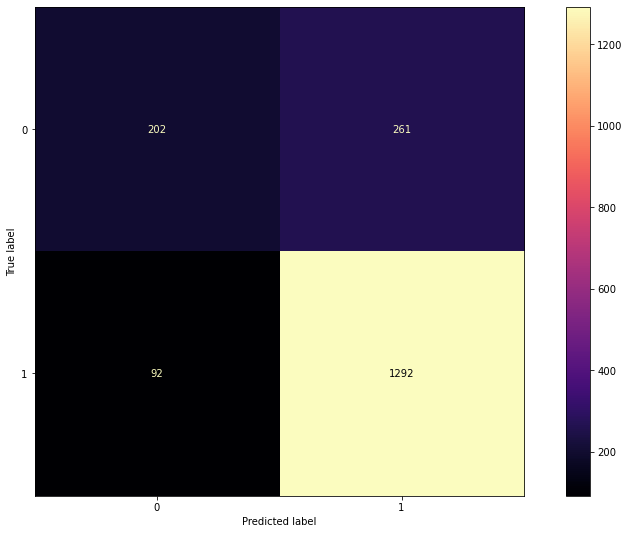

In [228]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'magma')
plt.show()

In [111]:
customLSTM.save(r'C:\Users\Cristina\OneDrive\Documentos\Curs SEPE\Projecte final/drug_review_nn')

INFO:tensorflow:Assets written to: C:\Users\Cristina\OneDrive\Documentos\Curs SEPE\Projecte final/drug_review_nn\assets


INFO:tensorflow:Assets written to: C:\Users\Cristina\OneDrive\Documentos\Curs SEPE\Projecte final/drug_review_nn\assets


### Custom 2

In [61]:
customLSTM2 = Sequential([
    # input_dim: size of the vocabulary (unique words)
    # output_dim: output vector size
    # input_length: sequences length
    Embedding(input_dim=max_words, output_dim=10, input_length=500),
    Dropout(0.4),
    LSTM(256, dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(28, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
customLSTM2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

customLSTM2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 10)           50000     
                                                                 
 dropout_3 (Dropout)         (None, 500, 10)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               273408    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [62]:
customLSTM2.fit(X_train, y_train, epochs=8, batch_size=256,verbose = 1,callbacks = callbacks_list,validation_split=0.2)

Epoch 1/8
24/24 [==============================] - 134s 5s/step - loss: 0.6607 - accuracy: 0.7503 - val_loss: 0.6031 - val_accuracy: 0.7508
Epoch 2/8
24/24 [==============================] - 135s 6s/step - loss: 0.5764 - accuracy: 0.7542 - val_loss: 0.5652 - val_accuracy: 0.7508
Epoch 3/8
24/24 [==============================] - 128s 5s/step - loss: 0.5580 - accuracy: 0.7542 - val_loss: 0.5483 - val_accuracy: 0.7508
Epoch 4/8
24/24 [==============================] - 130s 5s/step - loss: 0.5320 - accuracy: 0.7542 - val_loss: 0.5025 - val_accuracy: 0.7508
Epoch 5/8
24/24 [==============================] - 133s 6s/step - loss: 0.4382 - accuracy: 0.7657 - val_loss: 0.4551 - val_accuracy: 0.8091
Epoch 6/8
24/24 [==============================] - 127s 5s/step - loss: 0.3615 - accuracy: 0.8429 - val_loss: 0.4315 - val_accuracy: 0.8084
Epoch 7/8
24/24 [==============================] - 132s 5s/step - loss: 0.3527 - accuracy: 0.8522 - val_loss: 0.4285 - val_accuracy: 0.7989
Epoch 8/8
24/24 [===

In [202]:
y2_pred = customLSTM2.predict(X_test, verbose=0)
y2_pred = (y2_pred.flatten() > 0.5).astype(int)

In [203]:
'Test accuracy:', accuracy_score(y_test, y2_pred).round(4)

('Test accuracy:', 0.7997)

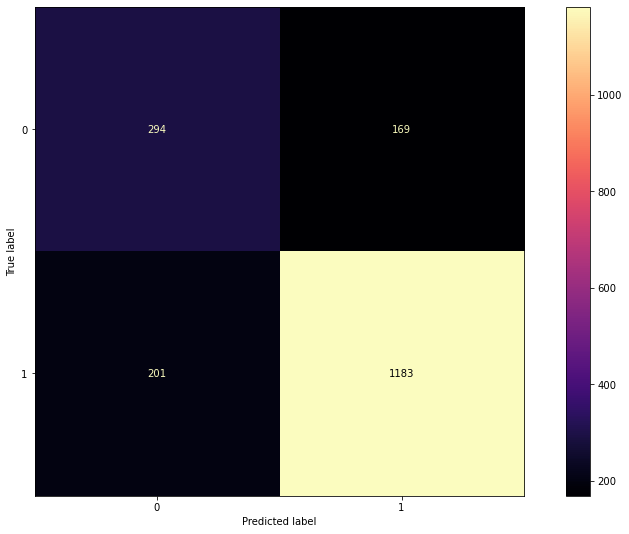

In [195]:
ConfusionMatrixDisplay.from_predictions(y_test, y2_pred, cmap = 'magma')
plt.show()

## LSTM with pre-trained embedding

In [65]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

11983


In [66]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(r'C:\Users\Cristina\OneDrive\Documentos\Curs SEPE\Projecte final/glove.6B.300d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [67]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [68]:
from tensorflow.keras.callbacks import EarlyStopping
pretrained_LSTM=Sequential()

#embedding layer
pretrained_LSTM.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=500,trainable=False)) 

#lstm layer
pretrained_LSTM.add(LSTM(256,return_sequences=True,dropout=0.2))

#Global Maxpooling
pretrained_LSTM.add(GlobalMaxPooling1D())

#Dense Layer
pretrained_LSTM.add(Dense(128,activation='relu'))
pretrained_LSTM.add(Dense(64,activation='relu')) 
pretrained_LSTM.add(Dense(32,activation='relu')) 
pretrained_LSTM.add(Dense(1,activation='sigmoid')) 

#Add loss function, metrics, optimizer
pretrained_LSTM.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(pretrained_LSTM.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 300)          3594900   
                                                                 
 lstm_2 (LSTM)               (None, 500, 256)          570368    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                      

In [69]:
pretrained_LSTM.fit(X_train, y_train, epochs=8, batch_size=256,verbose = 1,callbacks=[es,mc],validation_split=0.2)

Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 0.5655 - acc: 0.7542
Epoch 1: val_acc improved from -inf to 0.75085, saving model to best_model.h5
24/24 [==============================] - 221s 9s/step - loss: 0.5655 - acc: 0.7542 - val_loss: 0.5488 - val_acc: 0.7508
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 0.5310 - acc: 0.7542
Epoch 2: val_acc did not improve from 0.75085
24/24 [==============================] - 218s 9s/step - loss: 0.5310 - acc: 0.7542 - val_loss: 0.5154 - val_acc: 0.7508
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.4852 - acc: 0.7643
Epoch 3: val_acc improved from 0.75085 to 0.75965, saving model to best_model.h5
24/24 [==============================] - 244s 10s/step - loss: 0.4852 - acc: 0.7643 - val_loss: 0.5191 - val_acc: 0.7596
Epoch 4/8
24/24 [==============================] - ETA: 0s - loss: 0.4565 - acc: 0.7877
Epoch 4: val_acc did not improve from 0.75965
24/24 [=============================

In [183]:
y3_pred = pretrained_LSTM.predict(X_test, verbose=0)
y3_pred = (y3_pred.flatten() > 0.5).astype(int)

In [184]:
'Test accuracy:', accuracy_score(y_test, y3_pred).round(4)

('Test accuracy:', 0.7926)

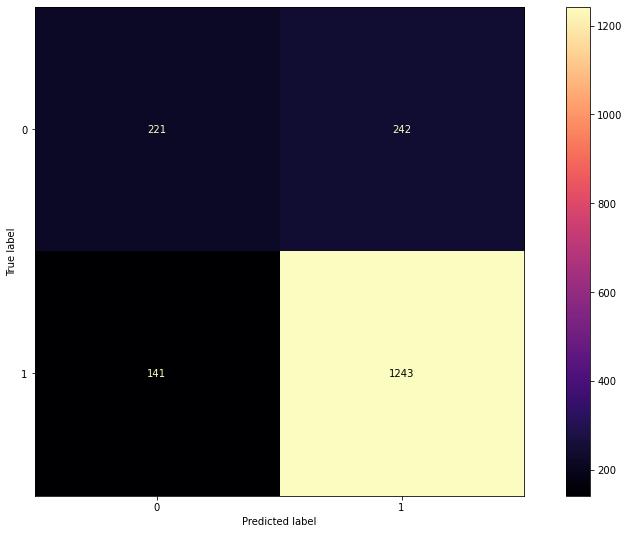

In [196]:
ConfusionMatrixDisplay.from_predictions(y_test, y3_pred, cmap = 'magma')
plt.show()

# Results

In [442]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ['Model', 'Accuracy']
table.add_row(['RF', 80.4])
table.add_row(['LGBM', 85.4])
table.add_row(['CB', 81.3])
table.add_row(['LSTM custom 1', 80.8])
table.add_row(['LSTM pretrained', 79.2])
print(table)

+-----------------+----------+
|      Model      | Accuracy |
+-----------------+----------+
|        RF       |   80.4   |
|       LGBM      |   85.4   |
|        CB       |   81.3   |
|  LSTM custom 1  |   80.8   |
| LSTM pretrained |   79.2   |
+-----------------+----------+
